#### Version1 Created by: Arindam Choudhury

# Understanding Networks through Clustering

Objective:

We are given the file ‘facebook_combined.txt’ from the Stanford SNAP repository, which provides a collection of real-world network datasets. The objective of this project is to use this given file to create a graph using any standard library, extract various local structural properties/features of the nodes, use various unsupervised clustering models to plot and observe/study different clusters and outliers.
    
Approach:

- Data Collection - Download ‘facebook_combined.txt’ file from Stanford SNAP repository, use Pandas DataFrame to load the external file

- Graph Representation - Convert the collected data using NetworkX into a non-directional Graph data structure, plot nodes and edges to represent its structure graphically

- Feature Engineering - As part of feature engineering, derive various informative features from local properties of nodes from the graph. Some of the properties are: number of first degree edges, second degree edges, number of triangles, clustering coefficient, neighbors degree, centrality, page rank and eigenvector etc. Additionally few features are engineered using python and numpy packages such as average, mean, median etc.

- Data Preparation - Perform EDA on extracted features, plot them using MatPlotLib and Seaborn libraries to observe data distribution, outliers and find for any missing value in any datapoint. Also as part of data preparation use SkLearn StandardScaler to scale the data, Normalizer to normalize the data and reduce dimensionality by performing Principle component Analysis (PCA) from SkLearn Preprocessing

- Clustering - Apply different clustering algorithms to group nodes based on extracted features. Unsupervised clustering models used are KMeans, AffinityPropagation, DBSCAN, AgglomerativeClustering, birch, Gaussian Mixture Models, Mini Batch KMeans clustering models from SkLearn and Hierarchical Clustering (using Linkage and CutTree) from SciPy. Each clastering model is analyzed to understand the clusters created and their relevancy/grouping with respect to the training data

- Evaluation and Tuning - Assess the quality of clusters by employing different evaluation metrices such as Silhouette score, Calinski Harabasz Index, Davies Bouldin Index, Pair-wise distances (from SkLearn metrics module), Distortion score (using distance SciPy spatial). Experiment with various tuning parameters for each model to find most effective parameters for clustering, fine tune them to generate most relatable clusters

- Interpretation and Analysis - Analyze each model and derive conclusion on the clustering pattern and outliers

Reporting and Documenting:

- Create report on each model and provide conclusion on clustering, also proposed best model for the given data

- Create report on Outliers / Anomaly

## 1 Import Required Libraries

In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
from networkx.algorithms.link_prediction import common_neighbor_centrality
from scipy import stats
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AffinityPropagation, Birch, DBSCAN, AgglomerativeClustering, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, pairwise_distances_argmin_min
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree

## 2 Data Collection

- Connect and get data from Google Drive:

In [ ]:
import os
os.chdir("Different_Clustering_Models_using_facebook_social_network_data")

- Read the Files

In [ ]:
df          = pd.read_csv("facebook_combined.txt", sep=" ", header=None, names=['member1', 'member2'])
df_sample   = pd.read_csv("facebook_combined_sample.txt", sep=" ", header=None, names=['member1', 'member2'])

## 3 Graph Representation

### 3.1 Create undirected Graph data structure using NetworkX

In [ ]:
G = nx.from_pandas_edgelist(df, 'member1', 'member2', create_using = nx.Graph())

# GET NODES AND DGREE:
NODES = G.nodes()
DEGREE = G.degree()

### 3.2 Plot the Graph

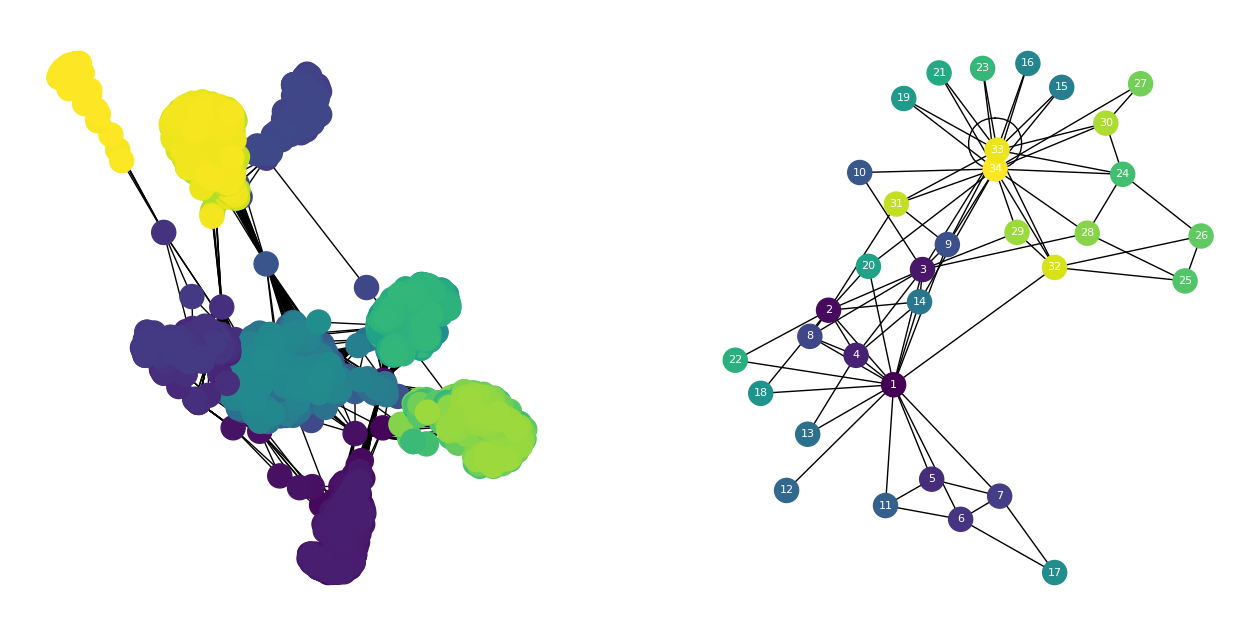

In [ ]:
# PLOT GRAPH
fig = plt.figure(figsize = (16,8), dpi=100)
plt.subplot(1,2,1)
nx.draw(G, node_color = NODES)

# PLOT GRAPH WITH SAMPLE DATASET GIVEN; THIS IS JUST FOR OBSERVATION
plt.subplot(1,2,2)
sample_G = nx.from_pandas_edgelist(df_sample, 'member1', 'member2', create_using = nx.Graph())
nx.draw(sample_G, with_labels= True, node_color = sample_G.nodes(), font_size = 8, font_color = 'w')

## 4 Feature Engineering

### 4.1. Derive various informative features of nodes from the Graph

- Get Degree; Degree = Number of First Connection

In [ ]:
# GET THE NUMBER OF CONNECTIONS FROM DEGREE:
df_degree = pd.DataFrame(DEGREE,columns=['member_id','Num_1st_connection'])

# ADD IT INTO THE FEATURE DATASET:
DF_Graph = df_degree

- Create Second and engineered features

Number of 2nd level connections

Average 2nd level connections

Minimum of 2nd level connections

Median of 2nd level connections

Average 3rd level connections

In [ ]:
# READ NODES SEQUENTIALLY, CALCULATE 2ND AND 3RD LEVEL CONNECTIONS
second_dict = {}
third_dict = {}
for node in NODES:

    total_2nd_connection = []

    edges_2nd = G.edges(node)
    for index_2nd, node_2nd in enumerate (edges_2nd):
        total_2nd_connection.append(DEGREE(node_2nd[1]))
        sum_2nd_connection = np.sum(total_2nd_connection)
        avg_2nd_connection = np.average(total_2nd_connection)
        min_2nd_connection = np.min(total_2nd_connection)
        median_2nd_connection = np.median(total_2nd_connection)

        total_3rd_connection = []
        edges_3rd = G.edges(node_2nd[0])
        for index_3rd, node_3rd in enumerate (edges_3rd):
            total_3rd_connection.append (DEGREE(node_3rd[1]))
        avg_3rd_connection = np.sum(total_3rd_connection)/sum_2nd_connection
        if node in third_dict.keys():
            third_dict.update({node: ((third_dict[node] + avg_3rd_connection) / 2)})
        else:
            third_dict[node] = avg_3rd_connection
    second_dict[node] = [sum_2nd_connection, avg_2nd_connection, min_2nd_connection, median_2nd_connection]

# ADD IT INTO THE FEATURE DATASET:
df_2nd_connection = pd.DataFrame.from_dict(second_dict, orient='index')
df_2nd_connection.columns = ['Num_2nd_connection', 'avg_2nd_connection', 'min_2nd_connection', 'median_2nd_connection']
df_2nd_connection.index.names = ['member_id']
DF_Graph = pd.merge(DF_Graph, df_2nd_connection, on='member_id')

# ADD IT INTO THE FEATURE DATASET:
df_3rd_connection = pd.DataFrame.from_dict(third_dict, orient='index')
df_3rd_connection.columns = ['avg_3rd_connection']
df_3rd_connection.index.names = ['member_id']
DF_Graph = pd.merge(DF_Graph, df_3rd_connection, on='member_id')


- Get Triangles
(Find number of triangles that include a node as one vertex)

In [ ]:
df_triangle = pd.DataFrame.from_dict(nx.triangles(G), orient='index')
df_triangle.columns = ['triangle']
df_triangle.index.names = ['member_id']

# ADD IT INTO THE FEATURE DATASET:
DF_Graph = pd.merge(DF_Graph, df_triangle, on='member_id')

- Get Clustering Coefficient (Compute the clustering coefficient for nodes)

In [ ]:
df_clust_coef = pd.DataFrame.from_dict(nx.clustering(G), orient='index')
df_clust_coef.columns = ['clust_coef']
df_clust_coef.index.names = ['member_id']

# ADD IT INTO THE FEATURE DATASET:
DF_Graph = pd.merge(DF_Graph, df_clust_coef, on='member_id')

- Get Average Neighbor Degree (Returns the average degree of the neighborhood of each node)

In [ ]:
df_avg_nei = pd.DataFrame.from_dict(nx.average_neighbor_degree(G), orient='index')
df_avg_nei.columns = ['avg_nei']
df_avg_nei.index.names = ['member_id']

# ADD IT INTO THE FEATURE DATASET:
DF_Graph = pd.merge(DF_Graph, df_avg_nei, on='member_id')

- Get Betweenness Centrality (Compute the shortest-path betweenness centrality for nodes)

In [ ]:
df_bet_cen = pd.DataFrame.from_dict(nx.betweenness_centrality(G), orient='index')
df_bet_cen.columns = ['bet_cen']
df_bet_cen.index.names = ['member_id']

# ADD IT INTO THE FEATURE DATASET:
DF_Graph = pd.merge(DF_Graph, df_bet_cen, on='member_id')

- Get PageRank (PageRank computes a ranking of the nodes in the graph G based on the structure of the incoming links. It was originally designed as an algorithm to rank web pages. Undirected graphs will be converted to a directed graph with two directed edges for each undirected edge)

In [ ]:
df_page_rank = pd.DataFrame.from_dict(nx.pagerank(G, alpha=0.85, personalization=None, max_iter=100, tol=1e-06, nstart=None, weight='weight', dangling=None), orient='index')
df_page_rank.columns = ['page_rank']
df_page_rank.index.names = ['member_id']

# ADD IT INTO THE FEATURE DATASET:
DF_Graph = pd.merge(DF_Graph, df_page_rank, on='member_id')

- Get Eigenvector_numpy (Eigenvector centrality computes the centrality for a node by adding the centrality of its predecessors. The centrality for node is the i-th element of a left eigenvector associated with the eigenvalue of maximum modulus that is positive)

In [ ]:
df_eg_numpy = pd.DataFrame.from_dict(nx.eigenvector_centrality_numpy(G, weight=None, max_iter=50, tol=0), orient='index')
df_eg_numpy.columns = ['eg_numpy']
df_eg_numpy.index.names = ['member_id']

# ADD IT INTO THE FEATURE DATASET:
DF_Graph = pd.merge(DF_Graph, df_eg_numpy, on='member_id')

- Get Closeness Centrality (Closeness centrality [1]_ of a node u is the reciprocal of the average shortest path distance to u over all n-1 reachable nodes)

In [ ]:
df_clo_cen = pd.DataFrame.from_dict(nx.closeness_centrality(G), orient='index')
df_clo_cen.columns = ['clo_cen']
df_clo_cen.index.names = ['member_id']

# ADD IT INTO THE FEATURE DATASET:
DF_Graph = pd.merge(DF_Graph, df_clo_cen, on='member_id')

- Get Information Centrality (Current-flow closeness centrality is variant of closeness centrality based on effective resistance between nodes in a network)

In [ ]:
df_info_cen = pd.DataFrame.from_dict(nx.information_centrality(G), orient='index')
df_info_cen.columns = ['info_cen']
df_info_cen.index.names = ['member_id']

# ADD IT INTO THE FEATURE DATASET:
DF_Graph = pd.merge(DF_Graph, df_info_cen, on='member_id')

- Get Load Centrality (The load centrality of a node is the fraction of all shortest paths that pass through that node)

In [ ]:
df_load_cen = pd.DataFrame.from_dict(nx.load_centrality(G), orient='index')
df_load_cen.columns = ['load_cen']
df_load_cen.index.names = ['member_id']

# ADD IT INTO THE FEATURE DATASET:
DF_Graph = pd.merge(DF_Graph, df_load_cen, on='member_id')

- Get Harmonic Centrality (Harmonic centrality [1]_ of a node u is the sum of the reciprocal of the shortest path distances from all other nodes to u)

In [ ]:
df_har_cen = pd.DataFrame.from_dict(nx.harmonic_centrality(G), orient='index')
df_har_cen.columns = ['har_cen']
df_har_cen.index.names = ['member_id']

# ADD IT INTO THE FEATURE DATASET:
DF_Graph = pd.merge(DF_Graph, df_har_cen, on='member_id')

- Get Approximate Current Flow Betweenness Centrality (Compute the approximate current-flow betweenness centrality for nodes)

In [ ]:
df_approx_curr_flow_bet_cen = pd.DataFrame.from_dict(nx.approximate_current_flow_betweenness_centrality(G), orient='index')
df_approx_curr_flow_bet_cen.columns = ['approx_curr_flow_bet_cen']
df_approx_curr_flow_bet_cen.index.names = ['member_id']

# ADD IT INTO THE FEATURE DATASET:
DF_Graph = pd.merge(DF_Graph, df_approx_curr_flow_bet_cen, on='member_id')

- Get Eigenvector Centrality (Eigenvector centrality computes the centrality for a node by adding the centrality of its predecessors. The centrality for node $i$ is the $i$-th element of a left eigenvector associated with the eigenvalue $\lambda$ of maximum modulus that is positive. Such an eigenvector $x$ is defined up to a multiplicative constant by the equation)

In [ ]:
df_eig_cen = pd.DataFrame.from_dict(nx.eigenvector_centrality(G), orient='index')
df_eig_cen.columns = ['eig_cen']
df_eig_cen.index.names = ['member_id']

# ADD IT INTO THE FEATURE DATASET:
DF_Graph = pd.merge(DF_Graph, df_eig_cen, on='member_id')

### 4.2 Create Model Training Dataset

In [ ]:
# DROP member_id, WE DO NOT NEED THIS FOR MODELING AND CLUSTERING
X = DF_Graph.drop(['member_id'] ,axis=1)

## 5 Data Preparation after EDA

- Describe the Dataset Features

In [ ]:
X.describe()

Num_1st_connection  Num_2nd_connection  avg_2nd_connection  \
count         4039.000000         4039.000000         4039.000000   
mean            43.691013         4656.144095          105.551793   
std             52.420605         7024.678749           91.313039   
min              1.000000           59.000000            6.016949   
25%             11.000000          884.000000           61.474571   
50%             25.000000         1747.000000           83.500000   
75%             57.000000         4622.000000          126.699028   
max           1045.000000        61104.000000         1045.000000   

       min_2nd_connection  median_2nd_connection  avg_3rd_connection  \
count         4039.000000            4039.000000         4039.000000   
mean            23.080961              69.426467            1.059749   
std             77.946106              93.073111            0.747909   
min              1.000000               2.000000            1.000000   
25%              7.000000              26.000000            1.011401   
50%             11.000000              43.500000            1.018802   
75%             18.000000              76.000000            1.031966   
max           1045.000000            1045.000000           34.000000   

           triangle   clust_coef      avg_nei       bet_cen    page_rank  \
count   4039.000000  4039.000000  4039.000000  4.039000e+03  4039.000000   
mean    1197.333498     0.605547   105.551793  6.669574e-04     0.000248   
std     2713.327322     0.214462    91.313039  1.164634e-02     0.000259   
min        0.000000     0.000000     6.016949  0.000000e+00     0.000042   
25%       34.000000     0.466667    61.474571  3.997507e-07     0.000141   
50%      161.000000     0.600000    83.500000  2.918300e-06     0.000219   
75%      831.500000     0.752381   126.699028  1.515292e-05     0.000309   
max    30025.000000     1.000000  1045.000000  4.805181e-01     0.007615   

           eg_numpy      clo_cen     info_cen      load_cen      har_cen  \
count  4.039000e+03  4039.000000  4039.000000  4.039000e+03  4039.000000   
mean   3.861377e-03     0.276168     0.001149  6.669574e-04  1237.962561   
std    1.525560e-02     0.036124     0.000398  1.157834e-02   166.937847   
min    3.634685e-14     0.178255     0.000144  0.000000e+00   770.076190   
25%    4.372482e-08     0.260348     0.000888  4.029420e-07  1147.919048   
50%    8.273741e-07     0.282457     0.001243  2.949162e-06  1260.966667   
75%    1.097124e-05     0.315001     0.001493  1.535436e-05  1391.816667   
max    9.540586e-02     0.459699     0.001745  4.714779e-01  2287.483333   

       approx_curr_flow_bet_cen       eig_cen  
count               4039.000000  4.039000e+03  
mean                   0.002609  3.864341e-03  
std                    0.009558  1.525485e-02  
min                    0.000000  6.385265e-14  
25%                    0.000460  5.388575e-08  
50%                    0.001115  8.885652e-07  
75%                    0.002605  3.266349e-05  
max                    0.337832  9.540696e-02

- Plot each feature to observe data spread

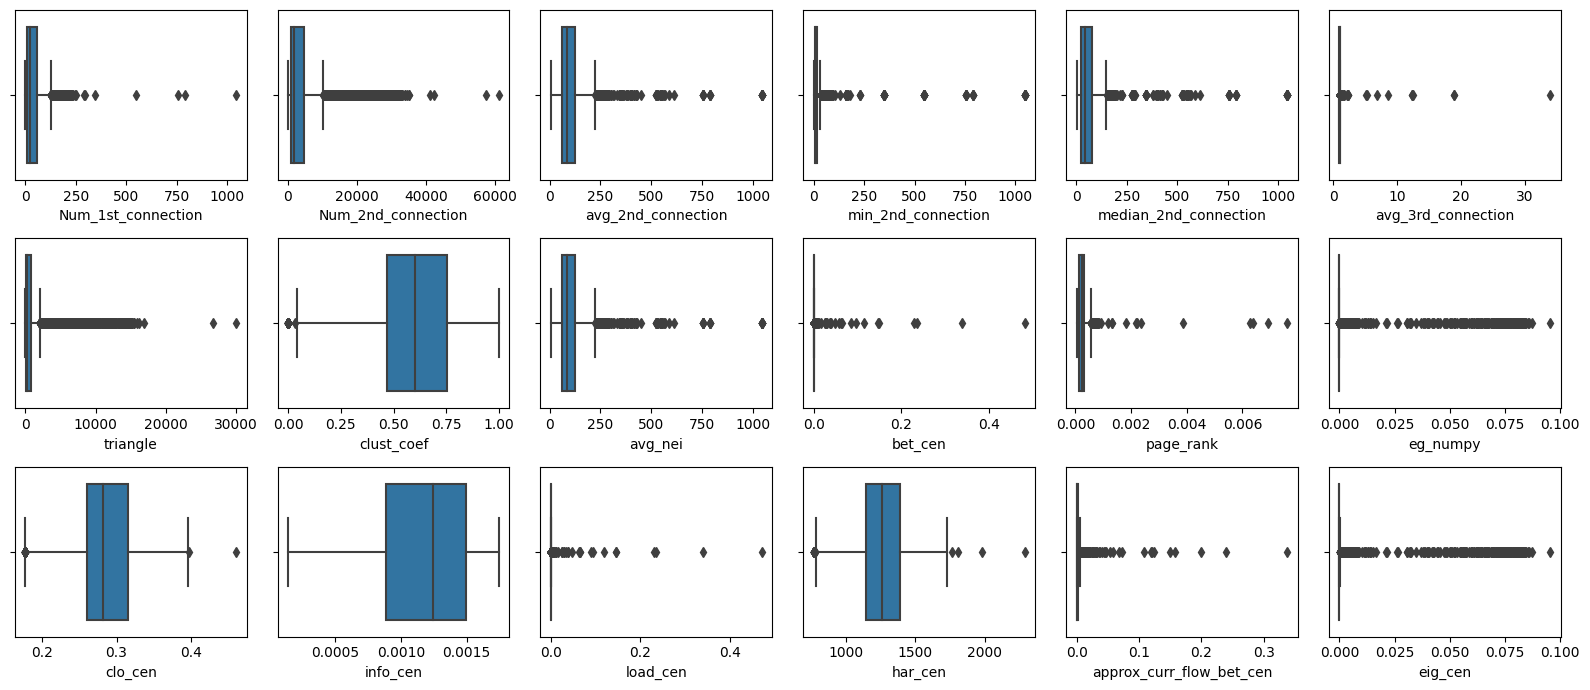

In [ ]:
# PLOT FEATURES USING BOXPLOT AND HISTPLOT
FEATURES = X.columns
fig = plt.subplots(figsize=(16,7))
plt.subplots_adjust(right=1, top=1)

for i, feature in enumerate (FEATURES, 1):
    plt.subplot(3, 6, i)
    sns.boxplot(x=feature, data=X)
    plt.xlabel(feature)
    plt.tight_layout()

- Plot each feature to observe data distribution

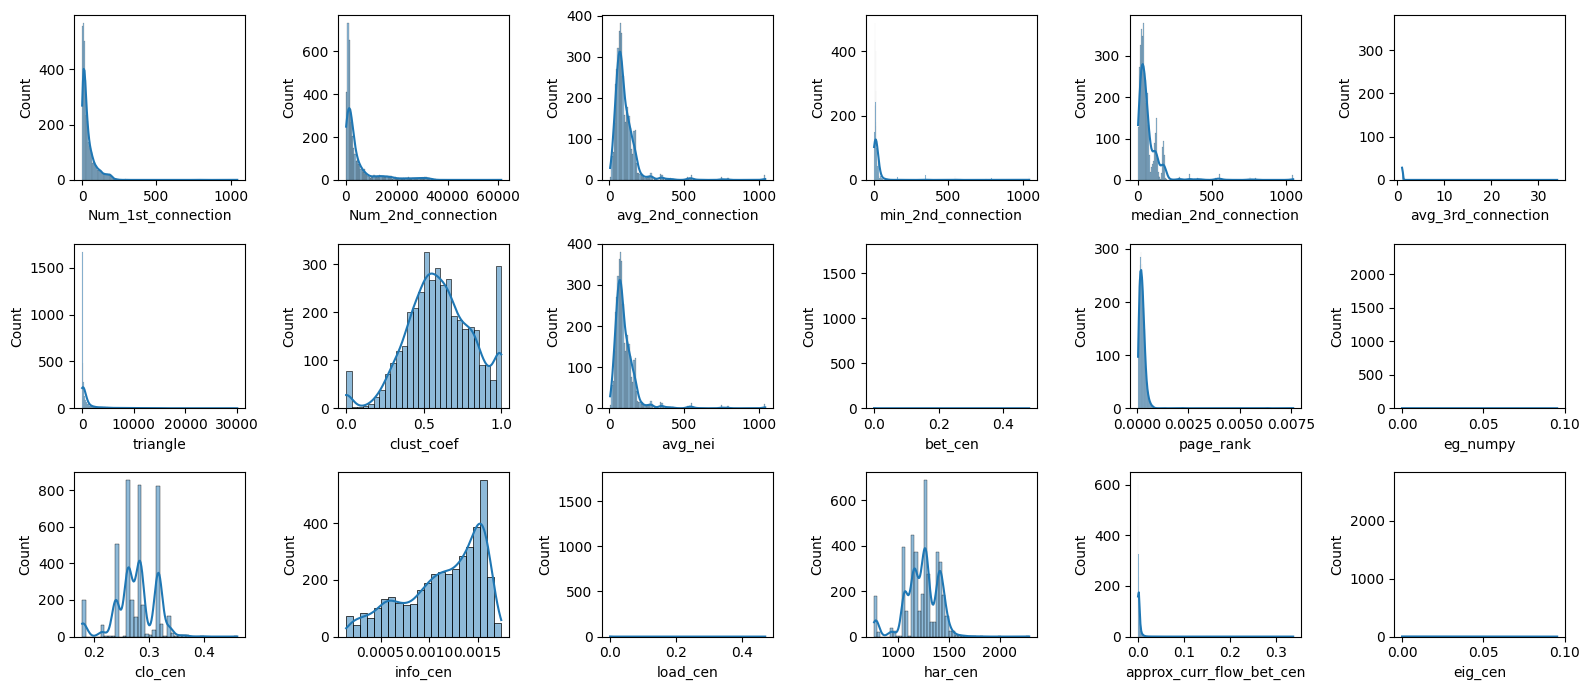

In [ ]:
# OBSERVE THE DISTRIBUTION
fig = plt.subplots(figsize=(16,7))
plt.subplots_adjust(right=1, top=1)

for i, feature in enumerate (FEATURES, 1):
    plt.subplot(3, 6, i)
    #sns.histplot(x=feature, data=X, kde=True, bins='sturges')
    sns.histplot(x=feature, data=X, kde=True)
    plt.xlabel(feature)
    plt.tight_layout()

- Observe the Correlation
(Some of these features are highly corelated; PCA will be performed to compress the dimension)


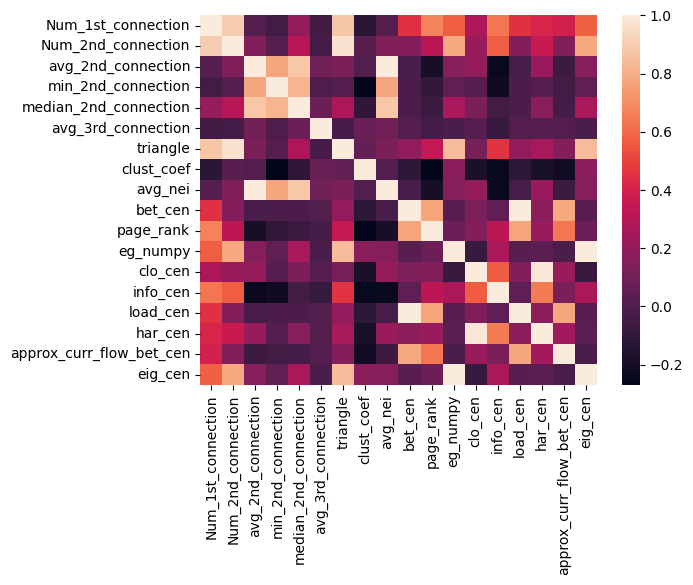

In [ ]:
sns.heatmap(X.corr())
plt.show()

- Find any missing value in the dateset

In [ ]:
print(X.isnull().sum())

Num_1st_connection          0
Num_2nd_connection          0
avg_2nd_connection          0
min_2nd_connection          0
median_2nd_connection       0
avg_3rd_connection          0
triangle                    0
clust_coef                  0
avg_nei                     0
bet_cen                     0
page_rank                   0
eg_numpy                    0
clo_cen                     0
info_cen                    0
load_cen                    0
har_cen                     0
approx_curr_flow_bet_cen    0
eig_cen                     0
dtype: int64


- Data Standardization and Normalization using StandardScaler and Normalizer

In [ ]:
scaler = StandardScaler()
normalize = Normalizer()

X_scaled = scaler.fit_transform(X)
X_normal = normalize.fit_transform(X_scaled) # NORMALIZE THE SCALED DATA

- Plot distributions on Normalized data

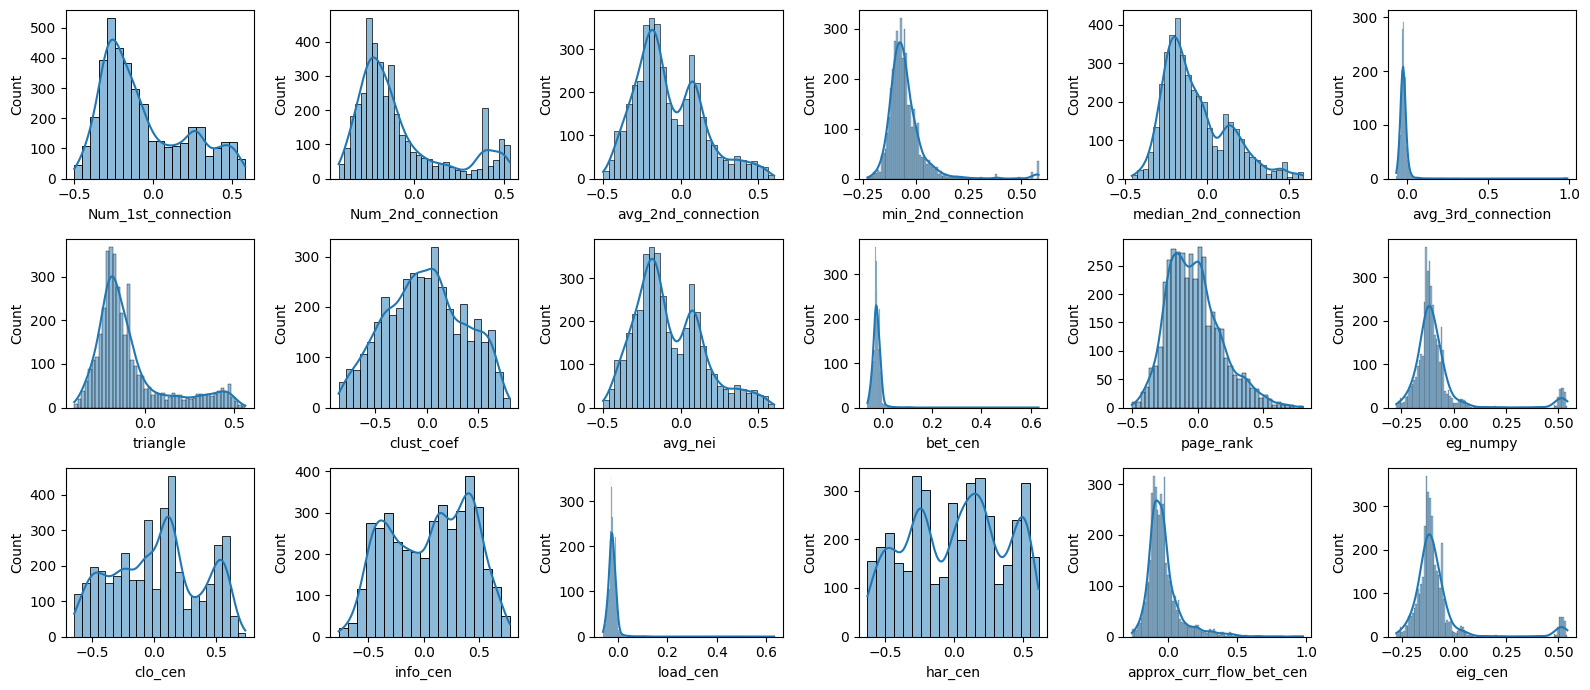

In [ ]:
DF_X_normal = pd.DataFrame(X_normal)
FEATURES = ['Num_1st_connection', 'Num_2nd_connection', 'avg_2nd_connection',
       'min_2nd_connection', 'median_2nd_connection', 'avg_3rd_connection',
       'triangle', 'clust_coef', 'avg_nei', 'bet_cen', 'page_rank', 'eg_numpy',
       'clo_cen', 'info_cen', 'load_cen', 'har_cen',
       'approx_curr_flow_bet_cen', 'eig_cen']
DF_X_normal.columns = FEATURES

# OBSERVE THE DISTRIBUTION AFTER NORMALIZATION
fig = plt.subplots(figsize=(16,7))
plt.subplots_adjust(right=1, top=1)

for i, feature in enumerate (FEATURES, 1):
    plt.subplot(3, 6, i)
    sns.histplot(x=feature, data=DF_X_normal, kde=True)
    plt.xlabel(feature)
    plt.tight_layout()

- Perform PCA to reduce dimention

In [ ]:
pca = PCA()
pca.fit(X_normal)

# FIND CUMULATIVE SUM OF ERROR
ssd = np.cumsum(pca.explained_variance_ratio_)
ssd

array([0.4005347 , 0.607519  , 0.78235919, 0.88343312, 0.92666457,
       0.95413847, 0.96807338, 0.97830833, 0.98720414, 0.99227368,
       0.99510477, 0.99707955, 0.99827843, 0.99926127, 0.99999929,
       0.99999999, 1.        , 1.        ])

- PCA Optimization and Tuning

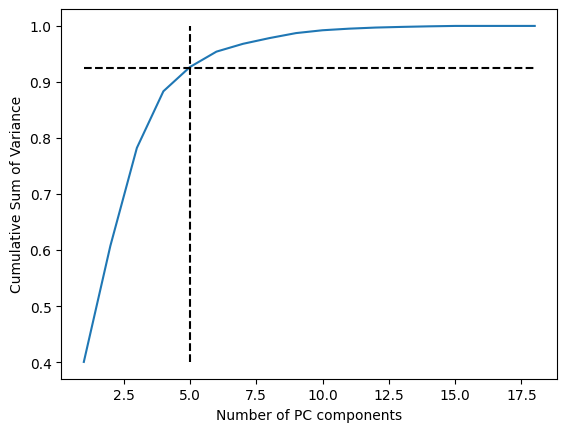

In [ ]:
NUMBER_OF_COMPONENTS = np.array(range(1,len(X.columns)+1)) #TOTAL NUMBER OF FEATURES

plt.plot(NUMBER_OF_COMPONENTS,ssd)
plt.vlines(x=5,ymax=max(ssd),ymin=min(ssd),color='black',linestyles='--')
plt.hlines(y=0.92572377,xmax=max(NUMBER_OF_COMPONENTS),xmin=min(NUMBER_OF_COMPONENTS),color='black',linestyles='--')
plt.ylabel("Cumulative Sum of Variance")
plt.xlabel("Number of PC components")
plt.show()

- Final PCA

n_components = 5 with 92% variance on data

In [ ]:
num_component = 5
PC_FEATURES = ['PC1','PC2','PC3','PC4','PC5']

pca = PCA(n_components=num_component)
X_pca = pca.fit_transform(X)

DF_X_pca = pd.DataFrame(X_pca, columns= PC_FEATURES) # PUT IT INTO A DATAFRAME FOR LATER USE

- 3D Prpjection of data in reduced dimention (PCA)

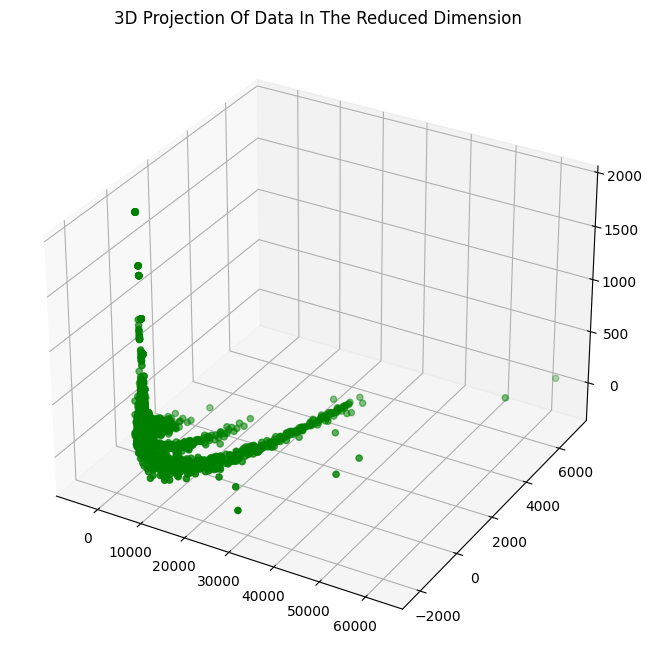

In [ ]:
x =DF_X_pca["PC1"]
y =DF_X_pca["PC2"]
z =DF_X_pca["PC3"]

# PLOT IN 3D:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="green", marker="o")
ax.set_title("3D Projection Of Data In The Reduced Dimension")
plt.show()

## 6 Clustering

#### 6.1 K-MEANS Clustering

K-means clustering is the most commonly used clustering algorithm. It's a centroid-based algorithm and the simplest unsupervised learning algorithm. This algorithm tries to minimize the variance of data points within a cluster.

- Evaluation, Refinement and Iteration

To identify a general estimate of the number of clusters to consider for the k-means approach, an elbow plot is created by calculating Sum of Square errors. The Elbow method is a heuristic method of interpretation and validation of consistency within cluster analysis designed to help finding the appropriate number of clusters in a dataset. It is often ambiguous and not very reliable, and hence other approaches for determining the number of clusters such as the Silhouette, calinski_harabasz_score,  davies_bouldin_score and distortion score are calculated and plotted to determine the best k clusters for this dataset.

In [ ]:
K_MEANS_CLUSTERS = np.array(range(2,10))

KMEANS_scores = {}
for num_cluster in K_MEANS_CLUSTERS:
    kmeans = KMeans(n_clusters=num_cluster, max_iter=1000, random_state=1).fit(X_pca)
    dist_score = sum(np.min(distance.cdist(X_pca, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X_pca.shape[0]
    sil_score = silhouette_score(X_pca, kmeans.labels_)
    calinski_harabasz_index = calinski_harabasz_score(X_pca, kmeans.labels_)
    davies_bouldin_index = davies_bouldin_score(X_pca, kmeans.labels_)
    print(f"num_cluster= {num_cluster},  SC= {sil_score}, CKI= {calinski_harabasz_index}, DBI= {davies_bouldin_index}, DS= {dist_score}, SSE= {kmeans.inertia_}")

    KMEANS_scores[num_cluster] = {'SSE' : kmeans.inertia_, 'SS' : sil_score,  'CKI' : calinski_harabasz_index, 'DBI' : davies_bouldin_index, 'DS' : dist_score}

num_cluster= 2,  SC= 0.8239510904918985, CKI= 13180.561803789169, DBI= 0.43062879674274757, DS= 2452.316013408486, SSE= 53748438565.758385
num_cluster= 3,  SC= 0.7828107259616849, CKI= 16785.709201678656, DBI= 0.4369220784236583, DS= 1778.4841389787969, SSE= 24601308436.58612
num_cluster= 4,  SC= 0.6828009794576357, CKI= 19718.843880556055, DBI= 0.4799977902033612, DS= 1254.1178132179418, SSE= 14637382116.372675
num_cluster= 5,  SC= 0.669386038173285, CKI= 20824.288249195568, DBI= 0.5208419044479115, DS= 1114.7139326605447, SSE= 10588768492.950546
num_cluster= 6,  SC= 0.611068606908401, CKI= 21500.31476996196, DBI= 0.547342107884996, DS= 943.710177997092, SSE= 8288910743.476786
num_cluster= 7,  SC= 0.6115900932887437, CKI= 24147.410601547046, DBI= 0.48117960476313754, DS= 925.7736898752084, SSE= 6206755894.724989
num_cluster= 8,  SC= 0.5825660389370009, CKI= 27944.72389409014, DBI= 0.5065920934834134, DS= 805.6354219444488, SSE= 4628445374.991161
num_cluster= 9,  SC= 0.5448518792361658

- Plot evaluation metrics

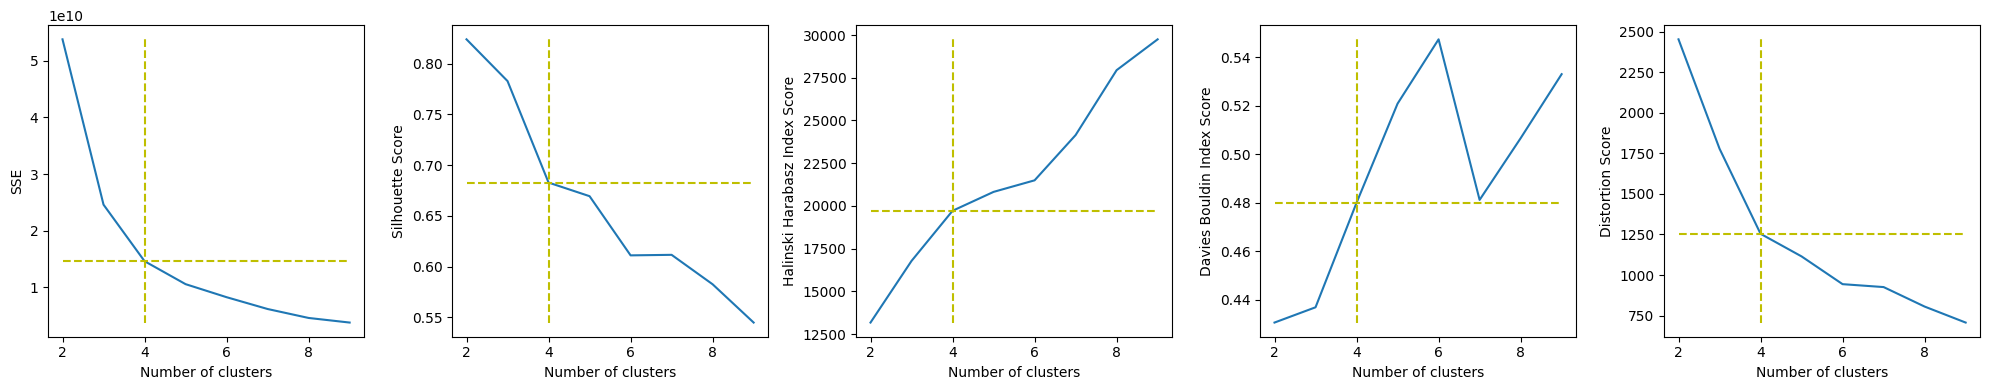

In [ ]:
plot_km_sc = pd.DataFrame.from_dict(KMEANS_scores, orient='index')
num_cluster = 4
fig = plt.subplots(figsize=(20,4))

# PLOT SSE FOR EACH CLUSTERS
plt.subplot(1,5,1)
plt.plot(K_MEANS_CLUSTERS, plot_km_sc['SSE'])
plt.vlines(x=num_cluster,ymax=max(plot_km_sc['SSE']),ymin=min(plot_km_sc['SSE']),color='y',linestyles='--')
plt.hlines(y=14637382116,xmax=max(K_MEANS_CLUSTERS),xmin=min(K_MEANS_CLUSTERS),color='y',linestyles='--')
plt.ylabel("SSE")
plt.xlabel("Number of clusters")

# PLOT SILHOUETTE SCORE FOR EACH CLUSTERS
plt.subplot(1,5,2)
plt.plot(K_MEANS_CLUSTERS, plot_km_sc['SS'])
plt.vlines(x=num_cluster,ymax=max(plot_km_sc['SS']),ymin=min(plot_km_sc['SS']),color='y',linestyles='--')
plt.hlines(y=0.6828009794576351,xmax=max(K_MEANS_CLUSTERS),xmin=min(K_MEANS_CLUSTERS),color='y',linestyles='--')
plt.ylabel("Silhouette Score")
plt.xlabel("Number of clusters")

# PLOT HALINSKI HARABASZ INDEX FOR EACH CLUSTERS
plt.subplot(1,5,3)
plt.plot(K_MEANS_CLUSTERS, plot_km_sc['CKI'])
plt.vlines(x=num_cluster,ymax=max(plot_km_sc['CKI']),ymin=min(plot_km_sc['CKI']),color='y',linestyles='--')
plt.hlines(y=19718,xmax=max(K_MEANS_CLUSTERS),xmin=min(K_MEANS_CLUSTERS),color='y',linestyles='--')
plt.ylabel("Halinski Harabasz Index Score")
plt.xlabel("Number of clusters")

# PLOT DAVIES BOULDIN INDEX FOR EACH CLUSTERS
plt.subplot(1,5,4)
plt.plot(K_MEANS_CLUSTERS, plot_km_sc['DBI'])
plt.vlines(x=num_cluster,ymax=max(plot_km_sc['DBI']),ymin=min(plot_km_sc['DBI']),color='y',linestyles='--')
plt.hlines(y=0.4799977902035947,xmax=max(K_MEANS_CLUSTERS),xmin=min(K_MEANS_CLUSTERS),color='y',linestyles='--')
plt.ylabel("Davies Bouldin Index Score")
plt.xlabel("Number of clusters")

# PLOT DISTORTION SCORE FOR EACH CLUSTERS
plt.subplot(1,5,5)
plt.plot(K_MEANS_CLUSTERS, plot_km_sc['DS'])
plt.vlines(x=num_cluster,ymax=max(plot_km_sc['DS']),ymin=min(plot_km_sc['DS']),color='y',linestyles='--')
plt.hlines(y=1254,xmax=max(K_MEANS_CLUSTERS),xmin=min(K_MEANS_CLUSTERS),color='y',linestyles='--')
plt.ylabel("Distortion Score")
plt.xlabel("Number of clusters")

plt.tight_layout()
plt.show()


- K-Means Final Model

It is observed from the above metrics, cluster size 4 is optimum for K-Means Classification Model

In [ ]:
kmeans = KMeans(n_clusters=4, max_iter=1000, random_state=1)
kmeans.fit(X_pca)

# ADD CLUSTER COLUMN TO THE PCA AND X DATAFRAME
DF_X_pca['K_Means_cluster_ID'] = kmeans.labels_
X['K_Means_cluster_ID'] = kmeans.labels_

- K-Means Plot clusters

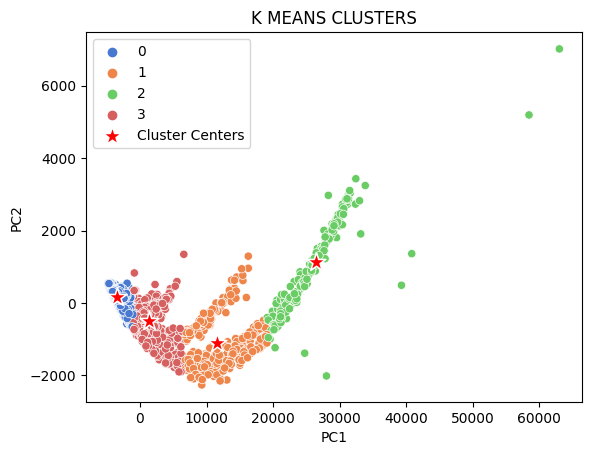

In [ ]:
# PLOT KMEANS CLUSTERS USING PC1 AND PC2 ALONG WITH CLUSTER CENTERS
centers = kmeans.cluster_centers_
sns.scatterplot(x='PC1',y='PC2',data=DF_X_pca,hue='K_Means_cluster_ID',palette = sns.color_palette("muted"))
sns.scatterplot(x=centers[:,0],y=centers[:,1],label="Cluster Centers" ,marker="*",facecolor="r",s=200)
plt.title('K MEANS CLUSTERS')
plt.show()

- Interpretation and clustering pattern Analysis

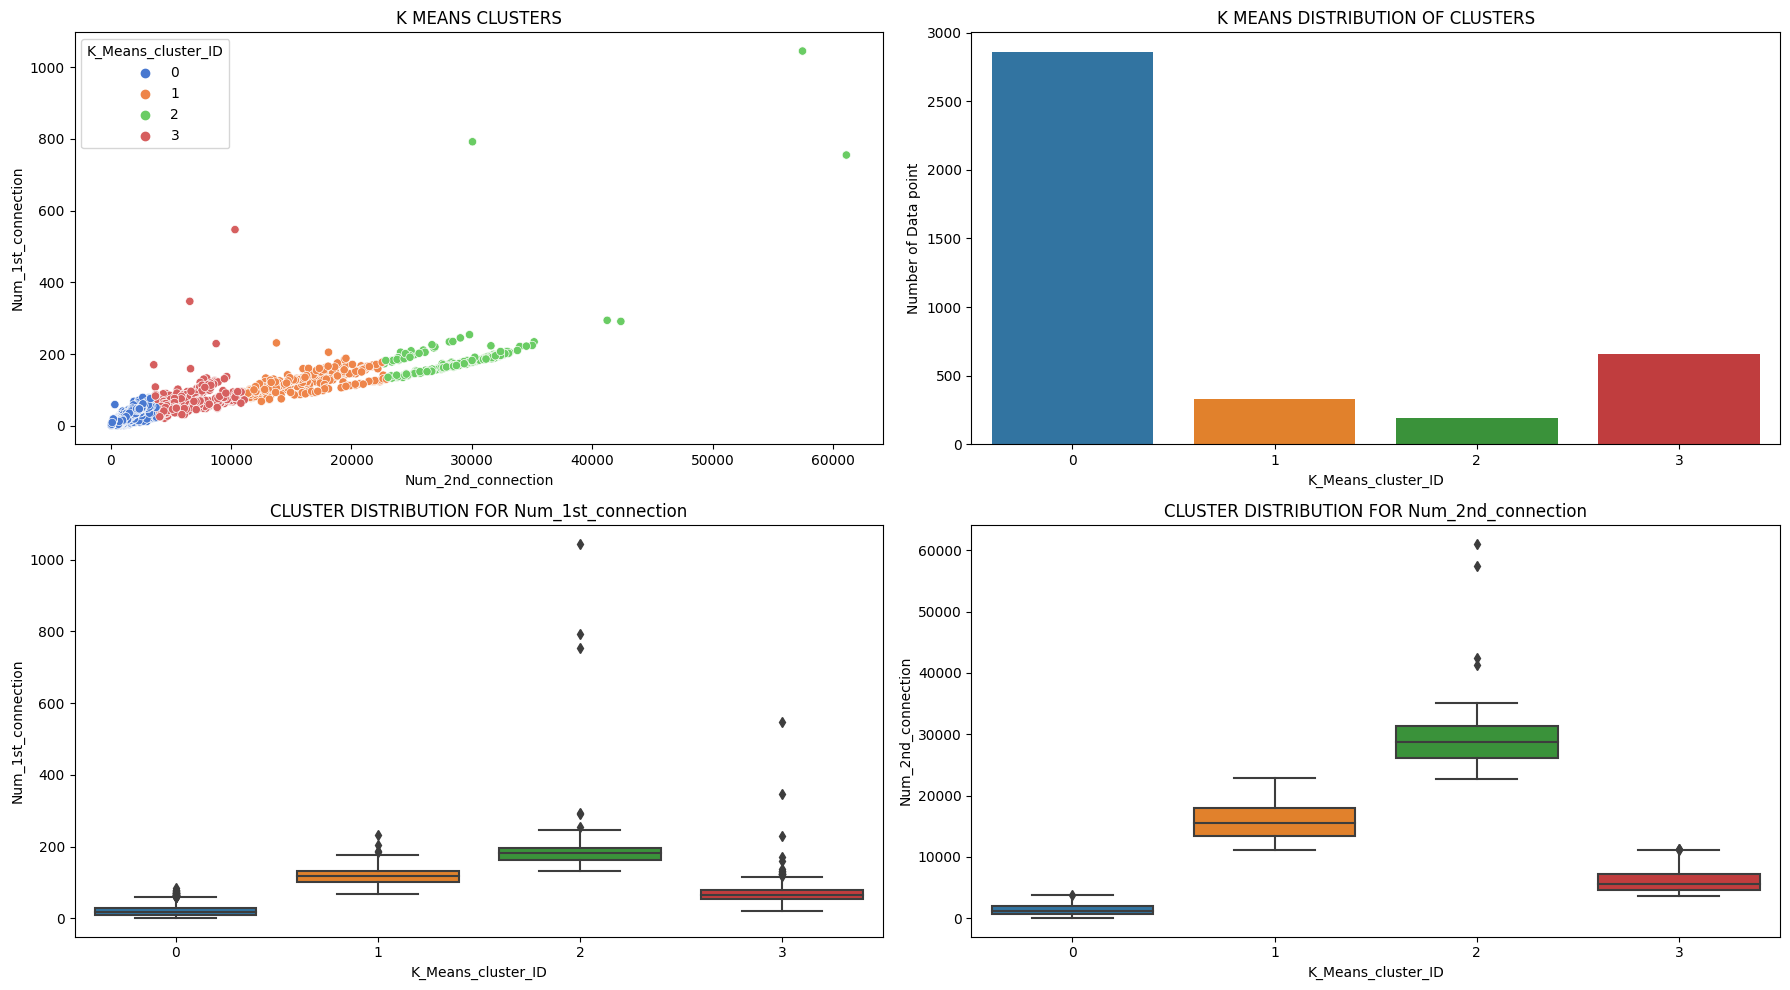

      
     Num_1st_connection Vs Num_2nd_connection plot shows the cluster pattern as:-   
        group 0: low number of 2nd connections
        group 1: high number of 2nd connections
        group 2: very-high number of 2nd connections
        group 3: moderate number of 2nd connections
    


In [ ]:
fig = plt.subplots(figsize=(18,10))

# PLOT KMEANS CLUSTERS USING Num_1st_connection AND Num_2nd_connection

plt.subplot(2,2,1)
sns.scatterplot(x='Num_2nd_connection',y='Num_1st_connection',data=X,hue='K_Means_cluster_ID',palette = sns.color_palette("muted"))
plt.title('K MEANS CLUSTERS')

# PLOT THE CLUSTER DISTRIBUTION
plt.subplot(2,2,2)
sns.countplot(X, x=X['K_Means_cluster_ID'])
plt.ylabel("Number of Data point")
plt.title('K MEANS DISTRIBUTION OF CLUSTERS')

# PLOT THE CLUSTER DISTRIBUTION
plt.subplot(2,2,3)
sns.boxplot(y=X["Num_1st_connection"],x=X["K_Means_cluster_ID"])
plt.title('CLUSTER DISTRIBUTION FOR Num_1st_connection')

# PLOT THE CLUSTER DISTRIBUTION
plt.subplot(2,2,4)
sns.boxplot(y=X["Num_2nd_connection"],x=X["K_Means_cluster_ID"])
plt.title('CLUSTER DISTRIBUTION FOR Num_2nd_connection')

plt.tight_layout()
plt.show()

print("""
     Num_1st_connection Vs Num_2nd_connection plot shows the cluster pattern as:-
        group 0: low number of 2nd connections
        group 1: high number of 2nd connections
        group 2: very-high number of 2nd connections
        group 3: moderate number of 2nd connections
    """)

#### 6.2 Affinity Propagation Clustering

Affinity Propagation involves finding a set of exemplars that best summarize the data. Affinity Propagation does not require the number of clusters to be specified beforehand. Instead, it iteratively adjusts the “responsibilities” and “availabilities” between data points to determine the number of clusters and the assignment of data points to those clusters

The key idea behind Affinity Propagation is that each data point can both act as an exemplar (representative) of its own cluster, and can also have a preference for being the exemplar of other data points. The algorithm seeks to find the exemplars that result in the highest total preference among all data points

- Evaluation, Refinement and Iteration

To find the optimum number of clusters, use damping factor to determine best suitable values of silhouette, calinski_harabasz_score,  davies_bouldin_score and distortion score are calculated and plotted to determine the best number clusters for this dataset.

In [ ]:
AP_score = {}
damping_factor = [0.5, 0.6, 0.7, 0.8, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.99]
for df in damping_factor:
    af = AffinityPropagation(damping=df, max_iter=4000)
    af.fit(X_pca)
    num_clusters = len(np.unique(af.labels_))
    sil_score = silhouette_score(X_pca, af.labels_)
    calinski_harabasz_index = calinski_harabasz_score(X_pca, af.labels_)
    davies_bouldin_index = davies_bouldin_score(X_pca, af.labels_)
    print(f"dumping = {df}, NC = {num_clusters},  SC score = {sil_score}, CKI= {calinski_harabasz_index}, DBI= {davies_bouldin_index}")
    AP_score[df] = {'NC':num_clusters, 'SS' : sil_score,  'CKI' : calinski_harabasz_index, 'DBI' : davies_bouldin_index}

dumping = 0.5, NC = 89,  SC score = 0.32796946042396347, CKI= 39731.155130540785, DBI= 0.6040602406879727
dumping = 0.6, NC = 66,  SC score = 0.3341466144862538, CKI= 52720.45266079926, DBI= 0.7300128169417756
dumping = 0.7, NC = 66,  SC score = 0.33624353837371995, CKI= 52960.24565799716, DBI= 0.7386206877286108
dumping = 0.8, NC = 63,  SC score = 0.3651302300345502, CKI= 52897.92333935709, DBI= 0.7004156618603248
dumping = 0.9, NC = 63,  SC score = 0.34607423356857503, CKI= 42638.928654243005, DBI= 0.7459106905192886
dumping = 0.91, NC = 63,  SC score = 0.35009909622522833, CKI= 42617.717051649204, DBI= 0.7312649073919825
dumping = 0.92, NC = 60,  SC score = 0.34514548054898697, CKI= 41396.61087142058, DBI= 0.7305922475284384
dumping = 0.93, NC = 61,  SC score = 0.34810608612125354, CKI= 42484.959866747915, DBI= 0.732566804642267
dumping = 0.94, NC = 62,  SC score = 0.3426066004924003, CKI= 51912.60680524152, DBI= 0.6963748907356128
dumping = 0.95, NC = 3,  SC score = 0.7746693890741

- Plot evaluation metrics

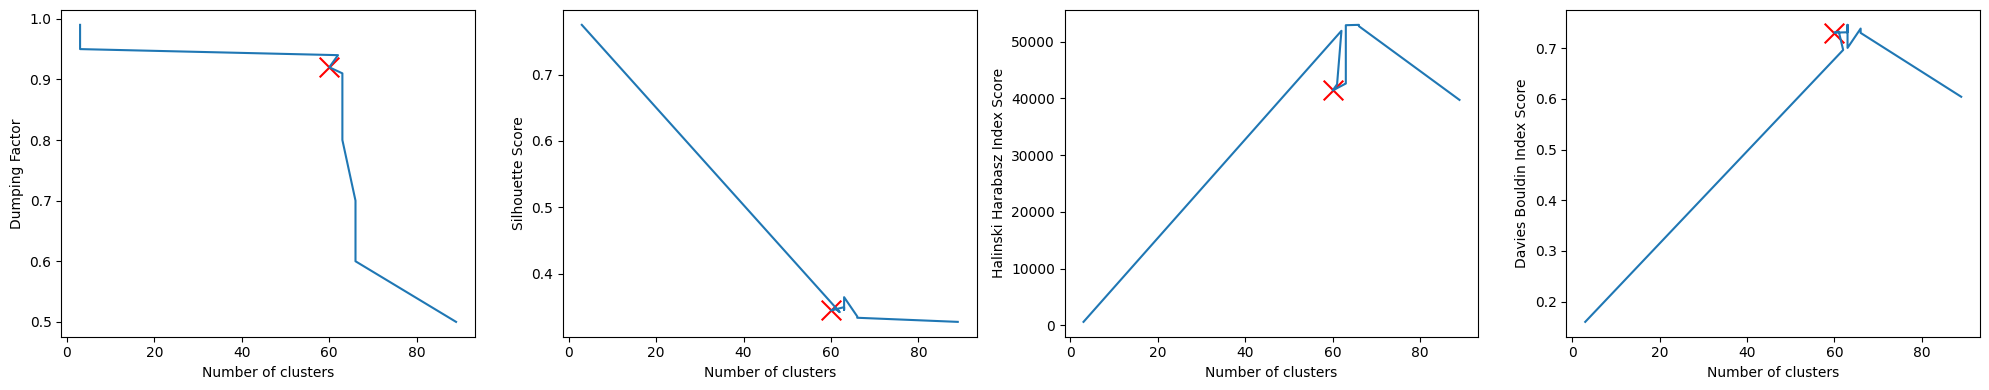

In [ ]:
plot_AP_sc = pd.DataFrame.from_dict(AP_score, orient='index')

fig = plt.subplots(figsize=(20,4))

# PLOT SILHOUETTE SCORE FOR EACH CLUSTERS
plt.subplot(1,4,1)
plt.plot(plot_AP_sc['NC'], damping_factor)
plt.scatter(60,.92,marker='x',color='red',s=200)
plt.ylabel("Dumping Factor")
plt.xlabel("Number of clusters")


# PLOT SILHOUETTE SCORE FOR EACH CLUSTERS
plt.subplot(1,4,2)
plt.plot(plot_AP_sc['NC'], plot_AP_sc['SS'])
plt.scatter(60,0.34514548053903293, marker='x',color='red',s=200)
plt.ylabel("Silhouette Score")
plt.xlabel("Number of clusters")


# PLOT HALINSKI HARABASZ INDEX FOR EACH CLUSTERS
plt.subplot(1,4,3)
plt.plot(plot_AP_sc['NC'], plot_AP_sc['CKI'])
plt.scatter(60,41396.6108715516, marker='x',color='red',s=200)
plt.ylabel("Halinski Harabasz Index Score")
plt.xlabel("Number of clusters")

# PLOT DAVIES BOULDIN INDEX FOR EACH CLUSTERS
plt.subplot(1,4,4)
plt.plot(plot_AP_sc['NC'], plot_AP_sc['DBI'])
plt.scatter(60,0.7305922475241762, marker='x',color='red',s=200)
plt.ylabel("Davies Bouldin Index Score")
plt.xlabel("Number of clusters")

plt.tight_layout()
plt.show()


- Affinity Propagation Plot clusters (With 3 Clusters)

In [ ]:
af = AffinityPropagation(damping=.95, max_iter=4000) #### WITH 3 CLUSTERS
af.fit(X_pca)

# ADD CLUSTER COLUMN TO THE PCA AND X DATAFRAME
DF_X_pca['AP_Cluster_ID'] = af.labels_
X['AP_Cluster_ID'] = af.labels_

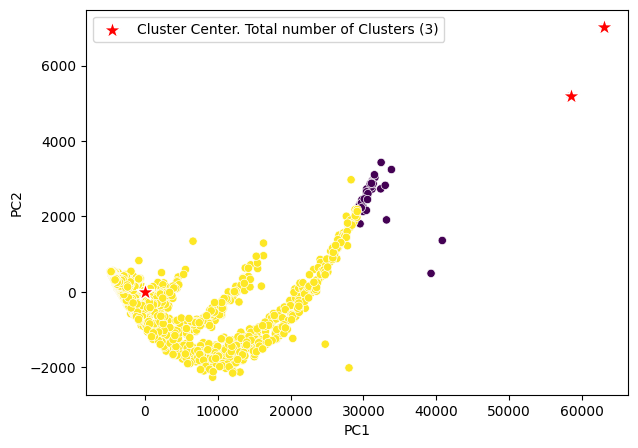

In [ ]:
# PLOT AP CLUSTERS USING PC1 AND PC2
centers = af.cluster_centers_
center_label = "Cluster Center. Total number of Clusters (" + str(len(np.unique(af.labels_))) + ")"
fig = plt.figure(figsize=[7,5],dpi=100)
sns.scatterplot(x='PC1',y='PC2',data=DF_X_pca,c=af.labels_,palette = sns.color_palette("muted"))
sns.scatterplot(x=centers[:,0],y=centers[:,1],label=center_label ,marker="*",facecolor="r",s=180)
plt.show()

- Affinity Propagation Final Models

It is observed from above evaluation; dumping factor =0.92 is best for classification here.

In [ ]:
af = AffinityPropagation(damping=.92, max_iter=4000) #### WITH 60 CLUSTERS
af.fit(X_pca)

# ADD CLUSTER COLUMN TO THE PCA AND X DATAFRAME
DF_X_pca['AP_Cluster_ID'] = af.labels_
X['AP_Cluster_ID'] = af.labels_

- Affinity Propagation Plot clusters (With 60 Clusters)

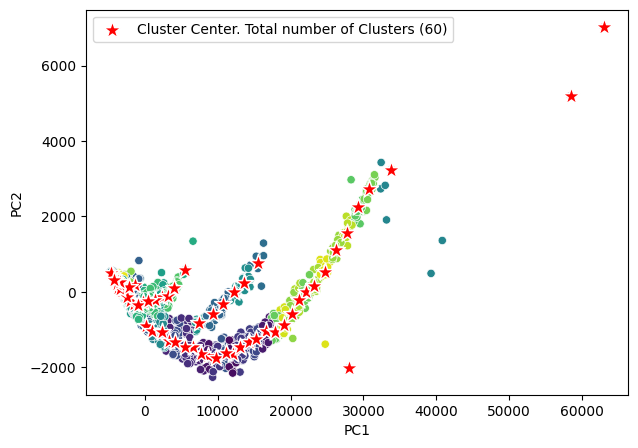

In [ ]:
# PLOT AP CLUSTERS USING PC1 AND PC2
centers = af.cluster_centers_
center_label = "Cluster Center. Total number of Clusters (" + str(len(np.unique(af.labels_))) + ")"
fig = plt.figure(figsize=[7,5],dpi=100)
sns.scatterplot(x='PC1',y='PC2',data=DF_X_pca,c=af.labels_,palette = sns.color_palette("muted"))
sns.scatterplot(x=centers[:,0],y=centers[:,1],label=center_label ,marker="*",facecolor="r",s=180)
plt.show()

- Interpretation and clustering pattern Analysis

Affinity Propagation generated too many clusters, As Affinity Propagation treats each data point can both act as an exemplar (representative) of its own cluster

### 6.3 Agglomerative Clustering (Hierarchical)

Agglomerative hierarchical clustering approach is a form of “bottom up” clustering “ each observation starts in its own cluster, and pairs of clusters are merged as one moves up the hierarchy

- Evaluation, Refinement and Iteration

In [ ]:
# CALCULATE PERFORMANCE SCORE FOR ALL LINKAGES VARYING NUMBER OF CLUSTERS
AG_CLUSTERS = np.array(range(2,10))
AG_score = {}

for num_cluster in AG_CLUSTERS:
  sl_ag = AgglomerativeClustering(n_clusters=num_cluster,compute_full_tree='auto',linkage='single')
  cl_ag = AgglomerativeClustering(n_clusters=num_cluster,compute_full_tree='auto',linkage='complete')
  av_ag = AgglomerativeClustering(n_clusters=num_cluster,compute_full_tree='auto',linkage='average')
  wd_ag = AgglomerativeClustering(n_clusters=num_cluster,compute_full_tree='auto',linkage='ward')

  sl_ag.fit(X_pca)
  sl_sil_score = silhouette_score(X_pca, sl_ag.labels_)
  sl_calinski_harabasz_index = calinski_harabasz_score(X_pca, sl_ag.labels_)
  sl_davies_bouldin_index = davies_bouldin_score(X_pca, sl_ag.labels_)

  cl_ag.fit(X_pca)
  cl_sil_score = silhouette_score(X_pca, cl_ag.labels_)
  cl_calinski_harabasz_index = calinski_harabasz_score(X_pca, cl_ag.labels_)
  cl_davies_bouldin_index = davies_bouldin_score(X_pca, cl_ag.labels_)

  av_ag.fit(X_pca)
  av_sil_score = silhouette_score(X_pca, av_ag.labels_)
  av_calinski_harabasz_index = calinski_harabasz_score(X_pca, av_ag.labels_)
  av_davies_bouldin_index = davies_bouldin_score(X_pca, av_ag.labels_)

  wd_ag.fit(X_pca)
  wd_sil_score = silhouette_score(X_pca, wd_ag.labels_)
  wd_calinski_harabasz_index = calinski_harabasz_score(X_pca, wd_ag.labels_)
  wd_davies_bouldin_index = davies_bouldin_score(X_pca, wd_ag.labels_)

  print(f"num_cluster = {num_cluster}, S_SC = {sl_sil_score}, S_CKI= {sl_calinski_harabasz_index}, S_DBI= {sl_davies_bouldin_index}, C_SC = {cl_sil_score}, C_CKI= {cl_calinski_harabasz_index}, C_DBI= {cl_davies_bouldin_index}, A_SC = {av_sil_score}, A_CKI= {av_calinski_harabasz_index}, A_DBI= {av_davies_bouldin_index}, W_SC = {wd_sil_score}, W_CKI= {wd_calinski_harabasz_index}, W_DBI= {wd_davies_bouldin_index}")
  AG_score[num_cluster] = {'S_SC' : sl_sil_score, 'S_CKI' : sl_calinski_harabasz_index, 'S_DBI' : sl_davies_bouldin_index, 'C_SC' : cl_sil_score, 'C_CKI' : cl_calinski_harabasz_index, 'C_DBI' : cl_davies_bouldin_index, 'A_SC' : av_sil_score, 'A_CKI' : av_calinski_harabasz_index, 'A_DBI' : av_davies_bouldin_index, 'W_SC' : wd_sil_score, 'W_CKI' : wd_calinski_harabasz_index, 'W_DBI' : wd_davies_bouldin_index}

num_cluster = 2, S_SC = 0.8789785863369509, S_CKI= 135.6594111182059, S_DBI= 0.12083519430034598, C_SC = 0.7955622322983805, C_CKI= 2998.6297215738186, C_DBI= 0.21116893174184811, A_SC = 0.8789785863369509, A_CKI= 135.6594111182059, A_DBI= 0.12083519430034598, W_SC = 0.8179558966467112, W_CKI= 12652.233470792778, W_DBI= 0.46263202485153676
num_cluster = 3, S_SC = 0.8005264872920606, S_CKI= 98.50637352983401, S_DBI= 0.15264981004383646, C_SC = 0.7915860566070074, C_CKI= 1553.4749563861315, C_DBI= 0.17582955402443223, A_SC = 0.8112960558835104, A_CKI= 3269.3991570384856, A_DBI= 0.21564725205654742, W_SC = 0.7625825965599988, W_CKI= 13827.32636710641, W_DBI= 0.4572518295934054
num_cluster = 4, S_SC = 0.8001417802918586, S_CKI= 65.73287426031479, S_DBI= 0.11206842980885823, C_SC = 0.7967155088289292, C_CKI= 8507.644936601286, C_DBI= 0.3454495928155899, A_SC = 0.8026995978593312, A_CKI= 2194.6138397634973, A_DBI= 0.24910548186204542, W_SC = 0.6706604680621575, W_CKI= 15502.511080742706, W_D

- Plot evaluation metrics

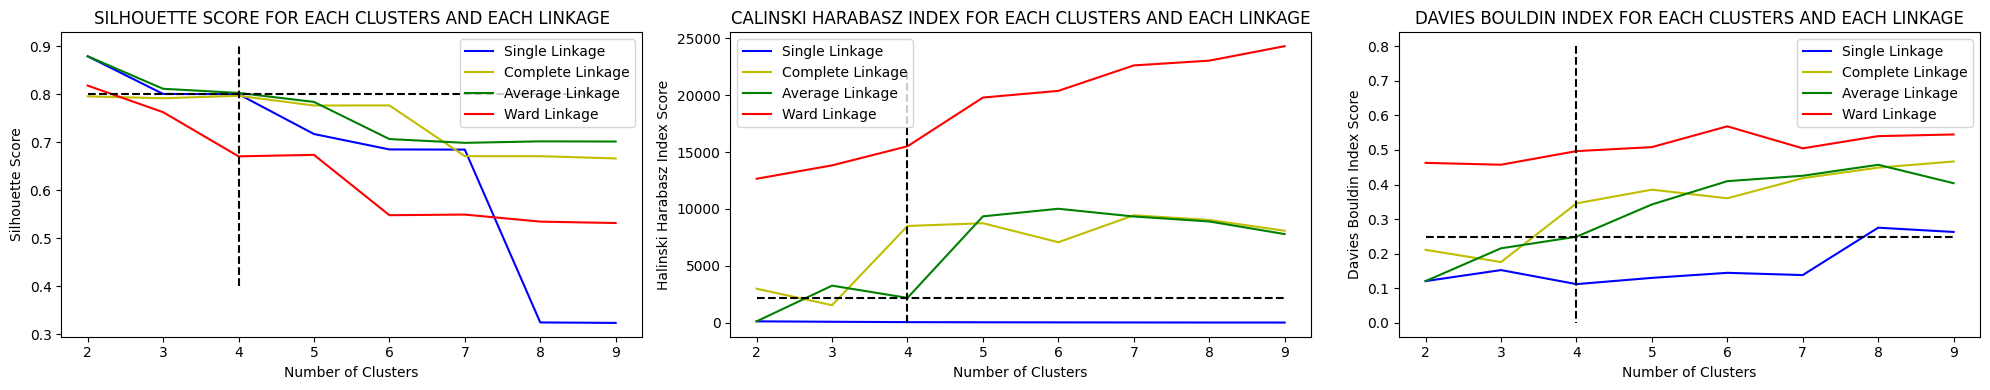

In [ ]:
# PLOT PERFORMANCE SCORE FOR ALL LINKAGES
plot_ag_sc = pd.DataFrame.from_dict(AG_score, orient='index')
fig = plt.subplots(figsize=(20,4))

# PLOT SILHOUETTE SCORE FOR EACH CLUSTERS AND EACH LINKAGE
plt.subplot(1,3,1)
plt.plot(AG_CLUSTERS,plot_ag_sc['S_SC'],c='b',label='Single Linkage')
plt.plot(AG_CLUSTERS,plot_ag_sc['C_SC'],c='y',label='Complete Linkage')
plt.plot(AG_CLUSTERS,plot_ag_sc['A_SC'],c='g',label='Average Linkage')
plt.plot(AG_CLUSTERS,plot_ag_sc['W_SC'],c='r',label='Ward Linkage')
plt.vlines(x=4,ymax=.9,ymin=.4,color='black',linestyles='--')
plt.hlines(y=0.8001417802918617,xmax=max(AG_CLUSTERS),xmin=min(AG_CLUSTERS),color='black',linestyles='--')
plt.legend()
plt.title('SILHOUETTE SCORE FOR EACH CLUSTERS AND EACH LINKAGE')
plt.ylabel("Silhouette Score")
plt.xlabel("Number of Clusters")

# PLOT CALINSKI HARABASZ INDEX FOR EACH CLUSTERS AND EACH LINKAGE
plt.subplot(1,3,2)
plt.plot(AG_CLUSTERS,plot_ag_sc['S_CKI'],c='b',label='Single Linkage')
plt.plot(AG_CLUSTERS,plot_ag_sc['C_CKI'],c='y',label='Complete Linkage')
plt.plot(AG_CLUSTERS,plot_ag_sc['A_CKI'],c='g',label='Average Linkage')
plt.plot(AG_CLUSTERS,plot_ag_sc['W_CKI'],c='r',label='Ward Linkage')
plt.vlines(x=4,ymax=0,ymin=22000,color='black',linestyles='--')
plt.hlines(y=2194.6138397634672,xmax=max(AG_CLUSTERS),xmin=min(AG_CLUSTERS),color='black',linestyles='--')
plt.legend()
plt.title('CALINSKI HARABASZ INDEX FOR EACH CLUSTERS AND EACH LINKAGE')
plt.ylabel("Halinski Harabasz Index Score")
plt.xlabel("Number of Clusters")

# PLOT DAVIES BOULDIN INDEX FOR EACH CLUSTERS AND EACH LINKAGE
plt.subplot(1,3,3)
plt.plot(AG_CLUSTERS,plot_ag_sc['S_DBI'],c='b',label='Single Linkage')
plt.plot(AG_CLUSTERS,plot_ag_sc['C_DBI'],c='y',label='Complete Linkage')
plt.plot(AG_CLUSTERS,plot_ag_sc['A_DBI'],c='g',label='Average Linkage')
plt.plot(AG_CLUSTERS,plot_ag_sc['W_DBI'],c='r',label='Ward Linkage')
plt.vlines(x=4,ymax=0,ymin=.8,color='black',linestyles='--')
plt.hlines(y=0.2491054818621491,xmax=max(AG_CLUSTERS),xmin=min(AG_CLUSTERS),color='black',linestyles='--')
plt.legend()
plt.title('DAVIES BOULDIN INDEX FOR EACH CLUSTERS AND EACH LINKAGE')
plt.ylabel("Davies Bouldin Index Score")
plt.xlabel("Number of Clusters")

plt.tight_layout()
plt.show()

- Agglomerative Clustering Final Model

Observed from above is that number of cluster = 4 and Linkage = Average is best suitable for clustering here

In [ ]:
ag = AgglomerativeClustering(n_clusters=4,linkage="average")
ag.fit(X_pca)
DF_X_pca ['AG_cluster_ID'] = ag.labels_
X ['AG_cluster_ID'] = ag.labels_

- Agglomerative Clustering Plot clusters

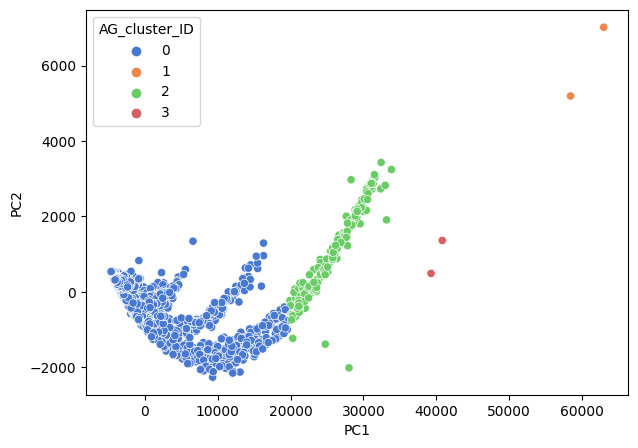

In [ ]:
# PLOT AGGLOMERATIVE CLUSTERS USING PC1 AND PC2
fig = plt.figure(figsize=[7,5],dpi=100)
sns.scatterplot(x='PC1',y='PC2',data=DF_X_pca,hue='AG_cluster_ID',palette = sns.color_palette("muted"))
plt.show()

- Interpretation and clustering pattern Analysis

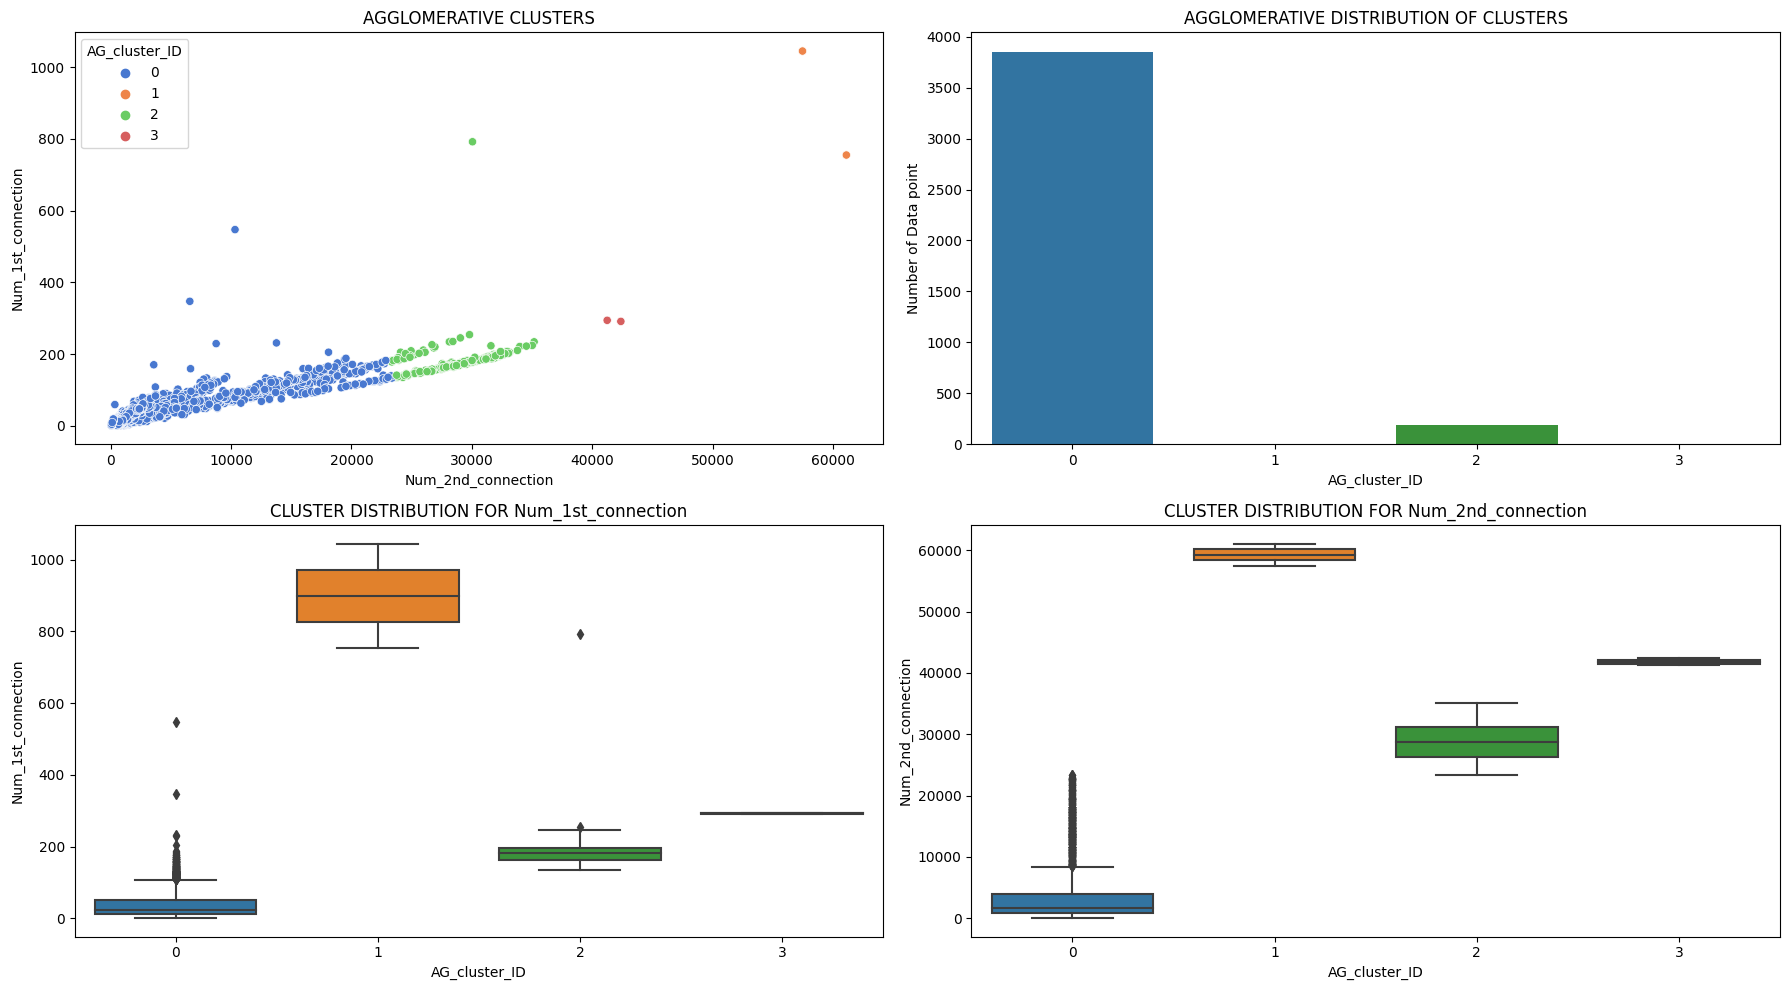

In [ ]:
fig = plt.subplots(figsize=(18,10))

# PLOT AGGLOMERATIVE CLUSTERS USING Num_1st_connection AND Num_2nd_connection

plt.subplot(2,2,1)
sns.scatterplot(x='Num_2nd_connection',y='Num_1st_connection',data=X,hue='AG_cluster_ID',palette = sns.color_palette("muted"))
plt.title('AGGLOMERATIVE CLUSTERS')

# PLOT THE CLUSTER DISTRIBUTION
plt.subplot(2,2,2)
sns.countplot(X, x=X['AG_cluster_ID'])
plt.ylabel("Number of Data point")
plt.title('AGGLOMERATIVE DISTRIBUTION OF CLUSTERS')

# PLOT THE CLUSTER DISTRIBUTION
plt.subplot(2,2,3)
sns.boxplot(y=X["Num_1st_connection"],x=X["AG_cluster_ID"])
plt.title('CLUSTER DISTRIBUTION FOR Num_1st_connection')

# PLOT THE CLUSTER DISTRIBUTION
plt.subplot(2,2,4)
sns.boxplot(y=X["Num_2nd_connection"],x=X["AG_cluster_ID"])
plt.title('CLUSTER DISTRIBUTION FOR Num_2nd_connection')

plt.tight_layout()
plt.show()

### 6.4 Divisive Clustering (Hierarchical Clustering) - [Using SCIPY Linkage, Dendrogram, Cut_tree]

Hierarchical clustering is a clustering algorithm that creates a hierarchy of clusters by recursively merging or splitting data points based on their similarity.

- Evaluation, Refinement and Iteration

It does not require the number of clusters to be specified in advance and provides a visual representation of the clustering structure through a dendrogram.

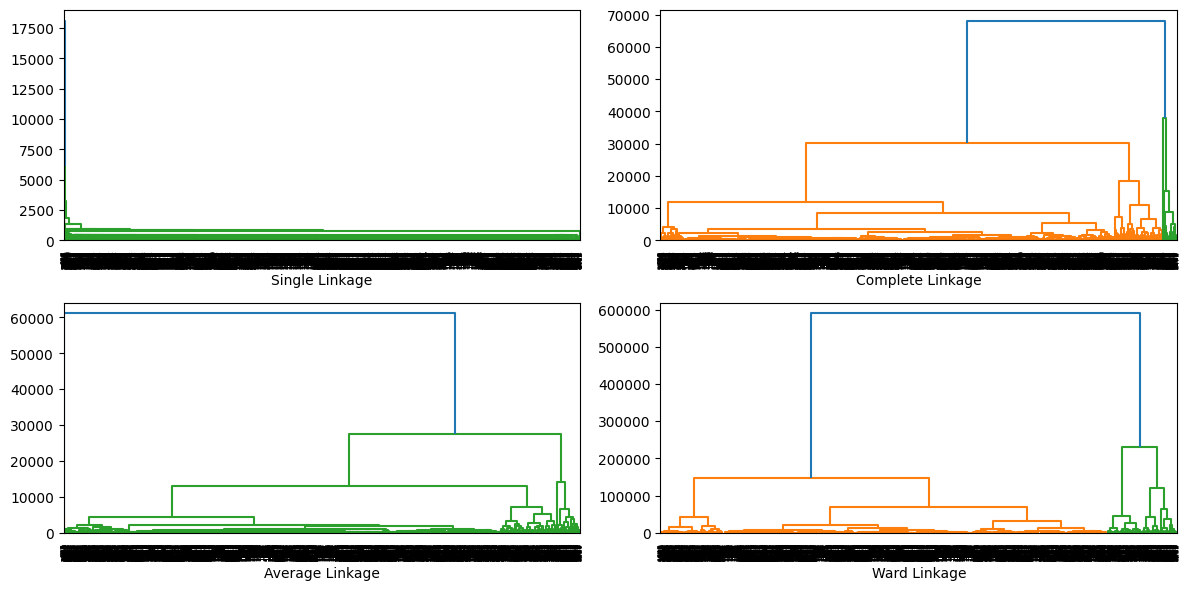

In [ ]:
fig = plt.subplots(figsize=(12,6))

# SINGLE LINKAGE
plt.subplot(2,2,1)
sl_mergings = linkage(X_pca, method="single", metric='euclidean')
dendrogram(sl_mergings)
plt.xlabel("Single Linkage")

# COMPLETE LINKAGE
plt.subplot(2,2,2)
cl_mergings = linkage(X_pca, method="complete", metric='euclidean')
dendrogram(cl_mergings)
plt.xlabel("Complete Linkage")

# AVERAGE LINKAGE
plt.subplot(2,2,3)
av_mergings = linkage(X_pca, method="average", metric='euclidean')
dendrogram(av_mergings)
plt.xlabel("Average Linkage")

# WARD LINKAGE
plt.subplot(2,2,4)
wd_mergings = linkage(X_pca, method="ward", metric='euclidean')
dendrogram(wd_mergings)
plt.xlabel("Ward Linkage")
plt.tight_layout()
plt.show()

In [ ]:
# CALCULATE PERFORMANCE SCORE FOR ALL LINKAGES VARYING NUMBER OF CLUSTERS
# ['single', 'complete', 'average', 'ward']

DV_HC_clusters = np.array(range(3,11))
DV_HC_score = {}

for num_cluster in DV_HC_clusters:
    sl_cluster_labels = cut_tree(sl_mergings, n_clusters=num_cluster).reshape(-1, )
    sl_sil_score = silhouette_score(X_pca, sl_cluster_labels)
    sl_calinski_harabasz_index = calinski_harabasz_score(X_pca, sl_cluster_labels)
    sl_davies_bouldin_index = davies_bouldin_score(X_pca, sl_cluster_labels)

    cl_cluster_labels = cut_tree(cl_mergings, n_clusters=num_cluster).reshape(-1, )
    cl_sil_score = silhouette_score(X_pca, cl_cluster_labels)
    cl_calinski_harabasz_index = calinski_harabasz_score(X_pca, cl_cluster_labels)
    cl_davies_bouldin_index = davies_bouldin_score(X_pca, cl_cluster_labels)

    av_cluster_labels = cut_tree(av_mergings, n_clusters=num_cluster).reshape(-1, )
    av_sil_score = silhouette_score(X_pca, av_cluster_labels)
    av_calinski_harabasz_index = calinski_harabasz_score(X_pca, av_cluster_labels)
    av_davies_bouldin_index = davies_bouldin_score(X_pca, av_cluster_labels)

    wd_cluster_labels = cut_tree(wd_mergings, n_clusters=num_cluster).reshape(-1, )
    av_sil_score = silhouette_score(X_pca, wd_cluster_labels)
    av_calinski_harabasz_index = calinski_harabasz_score(X_pca, wd_cluster_labels)
    av_davies_bouldin_index = davies_bouldin_score(X_pca, wd_cluster_labels)

    print(f"num_cluster = {num_cluster}, S_SC = {sl_sil_score}, S_CKI= {sl_calinski_harabasz_index}, S_DBI= {sl_davies_bouldin_index}, C_SC = {cl_sil_score}, C_CKI= {cl_calinski_harabasz_index}, C_DBI= {cl_davies_bouldin_index}, A_SC = {av_sil_score}, A_CKI= {av_calinski_harabasz_index}, A_DBI= {av_davies_bouldin_index}, W_SC = {wd_sil_score}, W_CKI= {wd_calinski_harabasz_index}, W_DBI= {wd_davies_bouldin_index}")
    DV_HC_score[num_cluster] = {'S_SC' : sl_sil_score, 'S_CKI' : sl_calinski_harabasz_index, 'S_DBI' : sl_davies_bouldin_index, 'C_SC' : cl_sil_score, 'C_CKI' : cl_calinski_harabasz_index, 'C_DBI' : cl_davies_bouldin_index, 'A_SC' : av_sil_score, 'A_CKI' : av_calinski_harabasz_index, 'A_DBI' : av_davies_bouldin_index, 'W_SC' : wd_sil_score, 'W_CKI' : wd_calinski_harabasz_index, 'W_DBI' : wd_davies_bouldin_index}

num_cluster = 3, S_SC = 0.8005264872920606, S_CKI= 98.50637352983401, S_DBI= 0.15264981004383646, C_SC = 0.7915860566070074, C_CKI= 1553.4749563861315, C_DBI= 0.17582955402443223, A_SC = 0.7625825965599988, A_CKI= 13827.32636710641, A_DBI= 0.4572518295934054, W_SC = 0.5318500911502584, W_CKI= 24290.521045070403, W_DBI= 0.5447182298406326
num_cluster = 4, S_SC = 0.8001417802918586, S_CKI= 65.73287426031479, S_DBI= 0.11206842980885823, C_SC = 0.7967155088289292, C_CKI= 8507.644936601286, C_DBI= 0.34544959281558985, A_SC = 0.6706604680621575, A_CKI= 15502.511080742706, A_DBI= 0.4965965401066418, W_SC = 0.5318500911502584, W_CKI= 24290.521045070403, W_DBI= 0.5447182298406326
num_cluster = 5, S_SC = 0.7171277951416064, S_CKI= 53.133968513815674, S_DBI= 0.1300936362733614, C_SC = 0.7764639646544204, C_CKI= 8747.985516370944, C_DBI= 0.3851852862482275, A_SC = 0.6737496270773872, A_CKI= 19779.104326267196, A_DBI= 0.5081663982900937, W_SC = 0.5318500911502584, W_CKI= 24290.521045070403, W_DBI= 

- Plot evaluation metrics

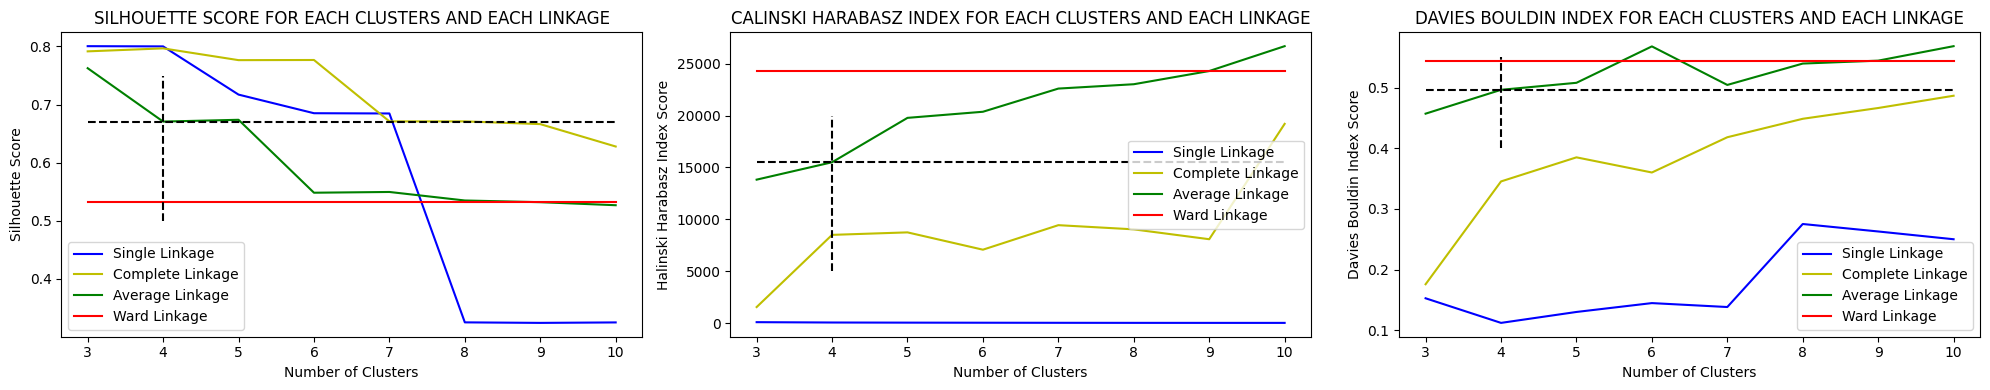

In [ ]:
# PLOT PERFORMANCE SCORE FOR ALL LINKAGES
plot_HC_DV_sc = pd.DataFrame.from_dict(DV_HC_score, orient='index')
fig = plt.subplots(figsize=(20,4))

# PLOT SILHOUETTE SCORE FOR EACH CLUSTERS AND EACH LINKAGE
plt.subplot(1,3,1)
plt.plot(DV_HC_clusters,plot_HC_DV_sc['S_SC'],c='b',label='Single Linkage')
plt.plot(DV_HC_clusters,plot_HC_DV_sc['C_SC'],c='y',label='Complete Linkage')
plt.plot(DV_HC_clusters,plot_HC_DV_sc['A_SC'],c='g',label='Average Linkage')
plt.plot(DV_HC_clusters,plot_HC_DV_sc['W_SC'],c='r',label='Ward Linkage')
plt.vlines(x=4,ymax=.75,ymin=.5,color='black',linestyles='--')
plt.hlines(y=0.670660468062239,xmax=max(DV_HC_clusters),xmin=min(DV_HC_clusters),color='black',linestyles='--')
plt.legend()
plt.title('SILHOUETTE SCORE FOR EACH CLUSTERS AND EACH LINKAGE')
plt.ylabel("Silhouette Score")
plt.xlabel("Number of Clusters")

# PLOT CALINSKI HARABASZ INDEX FOR EACH CLUSTERS AND EACH LINKAGE
plt.subplot(1,3,2)
plt.plot(DV_HC_clusters,plot_HC_DV_sc['S_CKI'],c='b',label='Single Linkage')
plt.plot(DV_HC_clusters,plot_HC_DV_sc['C_CKI'],c='y',label='Complete Linkage')
plt.plot(DV_HC_clusters,plot_HC_DV_sc['A_CKI'],c='g',label='Average Linkage')
plt.plot(DV_HC_clusters,plot_HC_DV_sc['W_CKI'],c='r',label='Ward Linkage')
plt.vlines(x=4,ymax=20000,ymin=5000,color='black',linestyles='--')
plt.hlines(y=15502.511080746568,xmax=max(DV_HC_clusters),xmin=min(DV_HC_clusters),color='black',linestyles='--')
plt.legend()
plt.title('CALINSKI HARABASZ INDEX FOR EACH CLUSTERS AND EACH LINKAGE')
plt.ylabel("Halinski Harabasz Index Score")
plt.xlabel("Number of Clusters")

# PLOT DAVIES BOULDIN INDEX FOR EACH CLUSTERS AND EACH LINKAGE
plt.subplot(1,3,3)
plt.plot(DV_HC_clusters,plot_HC_DV_sc['S_DBI'],c='b',label='Single Linkage')
plt.plot(DV_HC_clusters,plot_HC_DV_sc['C_DBI'],c='y',label='Complete Linkage')
plt.plot(DV_HC_clusters,plot_HC_DV_sc['A_DBI'],c='g',label='Average Linkage')
plt.plot(DV_HC_clusters,plot_HC_DV_sc['W_DBI'],c='r',label='Ward Linkage')
plt.vlines(x=4,ymax=.55,ymin=.4,color='black',linestyles='--')
plt.hlines(y=0.49659654010640625,xmax=max(DV_HC_clusters),xmin=min(DV_HC_clusters),color='black',linestyles='--')
plt.legend()
plt.title('DAVIES BOULDIN INDEX FOR EACH CLUSTERS AND EACH LINKAGE')
plt.ylabel("Davies Bouldin Index Score")
plt.xlabel("Number of Clusters")

plt.tight_layout()
plt.show()

- Divisive Clustering (Hierarchical Clustering) Final Model

Number of cluster = 4, Linkage = Average

In [ ]:
av_cluster_labels = cut_tree(av_mergings, n_clusters=4).reshape(-1, )
DF_X_pca ['DV_HC_av_ID'] = av_cluster_labels
X ['DV_HC_av_ID'] = av_cluster_labels

- Divisive Clustering (Hierarchical Clustering) Plot clusters

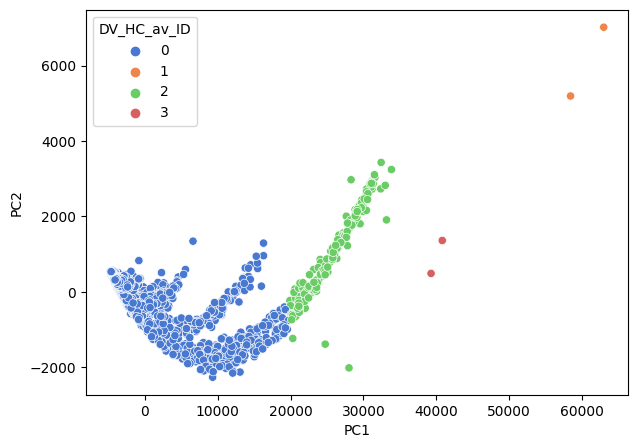

In [ ]:
# PLOT DIVISIVE CLUSTERING USING PC1 AND PC2
fig = plt.figure(figsize=[7,5],dpi=100)
sns.scatterplot(x='PC1',y='PC2',data=DF_X_pca,hue='DV_HC_av_ID',palette = sns.color_palette("muted"))
plt.show()

- Interpretation and clustering pattern Analysis

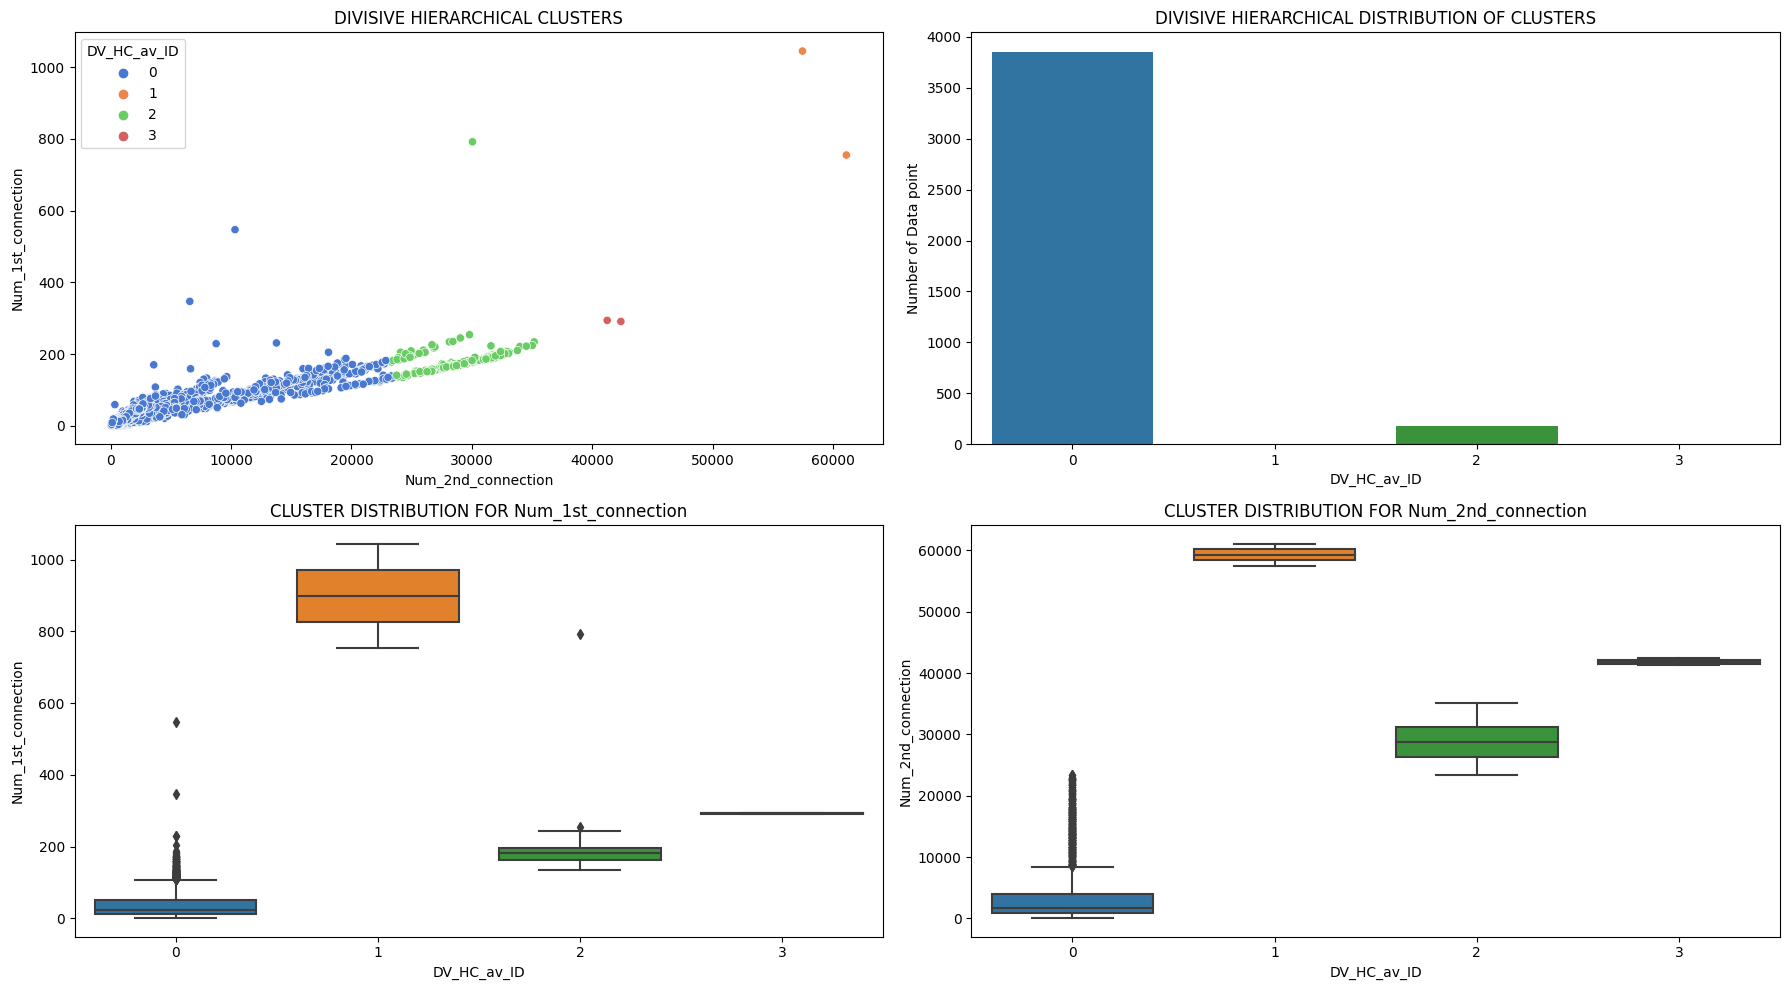

In [ ]:
fig = plt.subplots(figsize=(18,10))

# PLOT AGGLOMERATIVE CLUSTERS USING Num_1st_connection AND Num_2nd_connection

plt.subplot(2,2,1)
sns.scatterplot(x='Num_2nd_connection',y='Num_1st_connection',data=X,hue='DV_HC_av_ID',palette = sns.color_palette("muted"))
plt.title('DIVISIVE HIERARCHICAL CLUSTERS')

# PLOT THE CLUSTER DISTRIBUTION
plt.subplot(2,2,2)
sns.countplot(X, x=X['DV_HC_av_ID'])
plt.ylabel("Number of Data point")
plt.title('DIVISIVE HIERARCHICAL DISTRIBUTION OF CLUSTERS')

# PLOT THE CLUSTER DISTRIBUTION
plt.subplot(2,2,3)
sns.boxplot(y=X["Num_1st_connection"],x=X["DV_HC_av_ID"])
plt.title('CLUSTER DISTRIBUTION FOR Num_1st_connection')

# PLOT THE CLUSTER DISTRIBUTION
plt.subplot(2,2,4)
sns.boxplot(y=X["Num_2nd_connection"],x=X["DV_HC_av_ID"])
plt.title('CLUSTER DISTRIBUTION FOR Num_2nd_connection')

plt.tight_layout()
plt.show()

### 6.5 BIRCH Clustering (Hierarchical)

Balanced Iterative Reducing and Clustering using
Hierarchies) involves constructing a tree structure from which cluster centroids are extracted

- Evaluation, Refinement and Iteration

In [ ]:
BIRCH_score = {}
th_value = [0.5, 0.25, 0.2, 0.1, 0.05, 0.01]
BIRCH_cluster = np.array(range(3,9))
for nc in BIRCH_cluster:
  birch_0 = Birch(threshold=th_value[0], n_clusters=nc).fit(X_pca)
  ss_0 = silhouette_score(X_pca, birch_0.labels_)
  cki_0 = calinski_harabasz_score(X_pca, birch_0.labels_)
  dbi_0 = davies_bouldin_score(X_pca, birch_0.labels_)

  birch_1 = Birch(threshold=th_value[1], n_clusters=nc).fit(X_pca)
  ss_1 = silhouette_score(X_pca, birch_1.labels_)
  cki_1 = calinski_harabasz_score(X_pca, birch_1.labels_)
  dbi_1 = davies_bouldin_score(X_pca, birch_1.labels_)

  birch_2 = Birch(threshold=th_value[2], n_clusters=nc).fit(X_pca)
  ss_2 = silhouette_score(X_pca, birch_2.labels_)
  cki_2 = calinski_harabasz_score(X_pca, birch_2.labels_)
  dbi_2 = davies_bouldin_score(X_pca, birch_2.labels_)

  birch_3 = Birch(threshold=th_value[3], n_clusters=nc).fit(X_pca)
  ss_3 = silhouette_score(X_pca, birch_3.labels_)
  cki_3 = calinski_harabasz_score(X_pca, birch_3.labels_)
  dbi_3 = davies_bouldin_score(X_pca, birch_3.labels_)

  birch_4 = Birch(threshold=th_value[4], n_clusters=nc).fit(X_pca)
  ss_4 = silhouette_score(X_pca, birch_4.labels_)
  cki_4 = calinski_harabasz_score(X_pca, birch_4.labels_)
  dbi_4 = davies_bouldin_score(X_pca, birch_4.labels_)

  birch_5 = Birch(threshold=th_value[5], n_clusters=nc).fit(X_pca)
  ss_5 = silhouette_score(X_pca, birch_5.labels_)
  cki_5 = calinski_harabasz_score(X_pca, birch_5.labels_)
  dbi_5 = davies_bouldin_score(X_pca, birch_5.labels_)

  print(f"n_clusters: {nc}, TH: {th_value[0]}, SS: {ss_0}, CKI: {cki_0}, DBI: {dbi_0}, TH: {th_value[1]}, SS: {ss_1}, CKI: {cki_1}, DBI: {dbi_1}, TH: {th_value[2]}, SS: {ss_2}, CKI: {cki_2}, DBI: {dbi_2}, TH: {th_value[3]}, SS: {ss_3}, CKI: {cki_3}, DBI: {dbi_3}, TH: {th_value[4]}, SS: {ss_4}, CKI: {cki_4}, DBI: {dbi_4}, TH: {th_value[5]}, SS: {ss_5}, CKI: {cki_5}, DBI: {dbi_5}")
  # IT IS OBSERVED THAT SC, CKI AND DBI DO NOT CHANGE AFTER CHANGING Threshold value; Taking only default threshold value of 0.5
  BIRCH_score[nc] = {'SS': ss_0, 'CKI' : cki_0, 'DBI' : dbi_0}

n_clusters: 3, TH: 0.5, SS: 0.7625825965599988, CKI: 13827.32636710641, DBI: 0.4572518295934054, TH: 0.25, SS: 0.7625825965599988, CKI: 13827.32636710641, DBI: 0.4572518295934054, TH: 0.2, SS: 0.7625825965599988, CKI: 13827.32636710641, DBI: 0.4572518295934054, TH: 0.1, SS: 0.7625825965599988, CKI: 13827.32636710641, DBI: 0.4572518295934054, TH: 0.05, SS: 0.7625825965599988, CKI: 13827.32636710641, DBI: 0.4572518295934054, TH: 0.01, SS: 0.7625825965599988, CKI: 13827.32636710641, DBI: 0.4572518295934054
n_clusters: 4, TH: 0.5, SS: 0.6706604680621575, CKI: 15502.511080742706, DBI: 0.4965965401066418, TH: 0.25, SS: 0.6706604680621575, CKI: 15502.511080742706, DBI: 0.4965965401066418, TH: 0.2, SS: 0.6706604680621575, CKI: 15502.511080742706, DBI: 0.4965965401066418, TH: 0.1, SS: 0.6706604680621575, CKI: 15502.511080742706, DBI: 0.4965965401066418, TH: 0.05, SS: 0.6706604680621575, CKI: 15502.511080742706, DBI: 0.4965965401066418, TH: 0.01, SS: 0.6706604680621575, CKI: 15502.511080742706, 

- Plot evaluation metrics

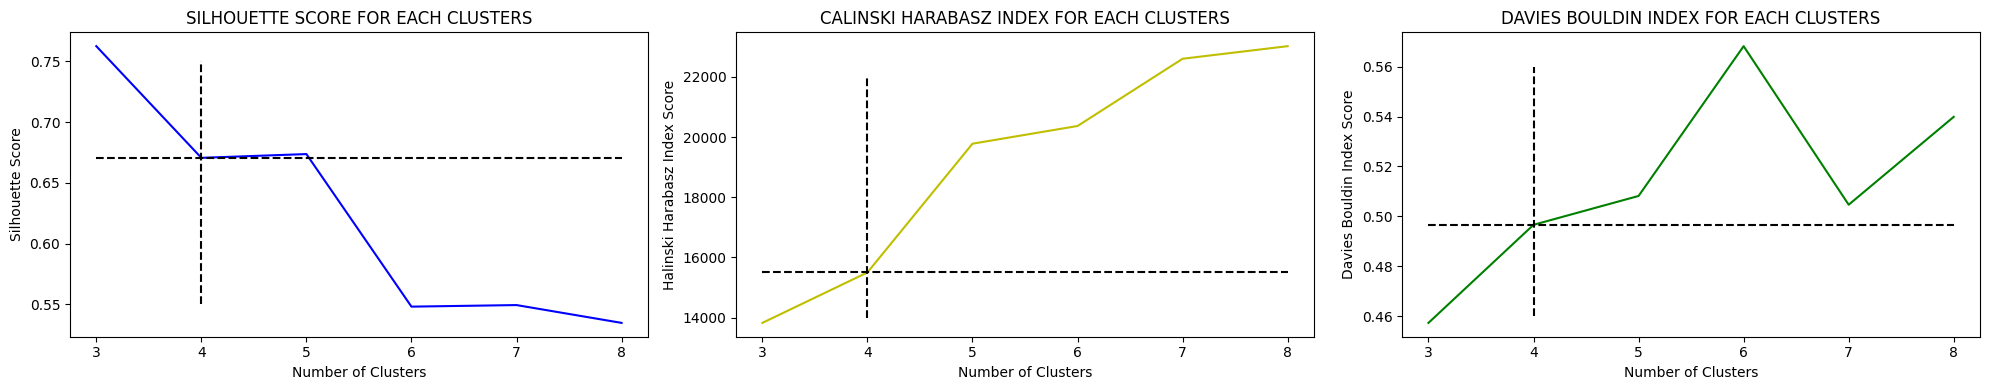

In [ ]:
# PLOT PERFORMANCE SCORE
plot_BIRCH_sc = pd.DataFrame.from_dict(BIRCH_score, orient='index')
fig = plt.subplots(figsize=(20,4))

# PLOT SILHOUETTE SCORE
plt.subplot(1,3,1)
plt.plot(BIRCH_cluster,plot_BIRCH_sc['SS'],c='b')
plt.vlines(x=4,ymax=.75,ymin=.55,color='black',linestyles='--')
plt.hlines(y=0.670660,xmax=max(BIRCH_cluster),xmin=min(BIRCH_cluster),color='black',linestyles='--')
plt.title('SILHOUETTE SCORE FOR EACH CLUSTERS')
plt.ylabel("Silhouette Score")
plt.xlabel("Number of Clusters")

# PLOT CALINSKI HARABASZ INDEX
plt.subplot(1,3,2)
plt.plot(BIRCH_cluster,plot_BIRCH_sc['CKI'],c='y')
plt.vlines(x=4,ymax=22000,ymin=14000,color='black',linestyles='--')
plt.hlines(y=15502.511081,xmax=max(BIRCH_cluster),xmin=min(BIRCH_cluster),color='black',linestyles='--')
plt.title('CALINSKI HARABASZ INDEX FOR EACH CLUSTERS')
plt.ylabel("Halinski Harabasz Index Score")
plt.xlabel("Number of Clusters")

# PLOT DAVIES BOULDIN INDEX
plt.subplot(1,3,3)
plt.plot(BIRCH_cluster,plot_BIRCH_sc['DBI'],c='g')
plt.vlines(x=4,ymax=.56,ymin=.46,color='black',linestyles='--')
plt.hlines(y=0.496597,xmax=max(BIRCH_cluster),xmin=min(BIRCH_cluster),color='black',linestyles='--')
plt.title('DAVIES BOULDIN INDEX FOR EACH CLUSTERS')
plt.ylabel("Davies Bouldin Index Score")
plt.xlabel("Number of Clusters")

plt.tight_layout()
plt.show()

- BIRCH Final Model

With 4 clusters, branching_factor=defaut (50) AND threshold=default (0.5)

In [ ]:
birch = Birch(n_clusters=4)
birch.fit(X_pca)
DF_X_pca ['BIRCH_cluster_ID'] = birch.labels_
X ['BIRCH_cluster_ID'] = birch.labels_

- BIRCH plot clusters

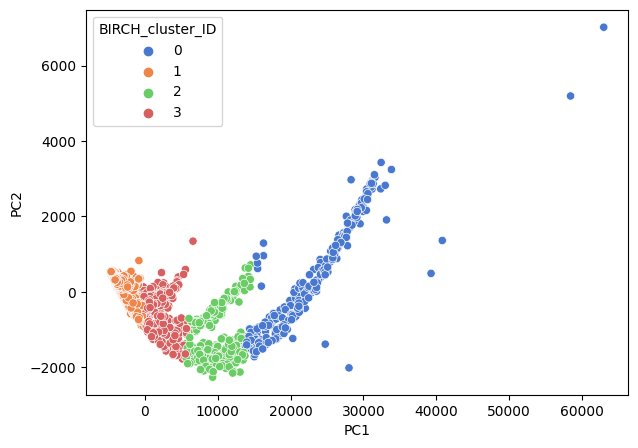

In [ ]:
# PLOT BIRCH CLUSTERING USING PC1 AND PC2
fig = plt.figure(figsize=[7,5],dpi=100)
sns.scatterplot(x='PC1',y='PC2',data=DF_X_pca,hue='BIRCH_cluster_ID', palette = sns.color_palette("muted"))
plt.show()

- Interpretation and clustering pattern Analysis

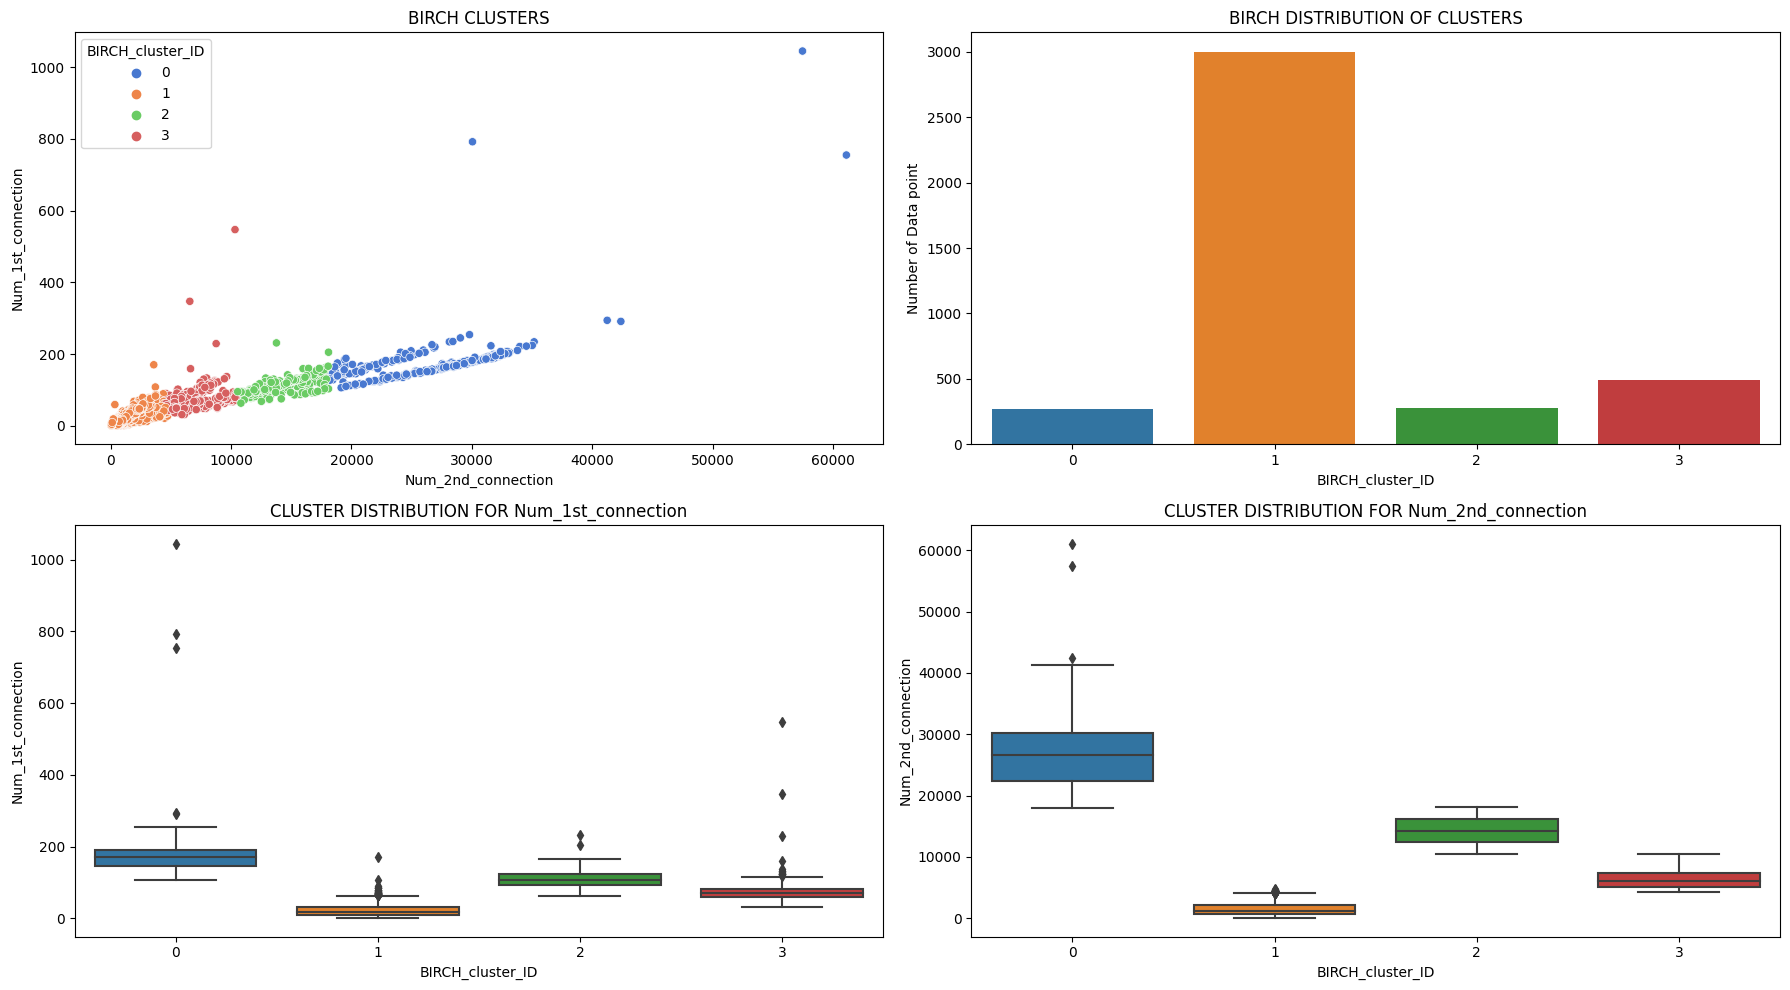

      
     Num_1st_connection Vs Num_2nd_connection plot shows the cluster pattern as:-   
        group 0: low number of 2nd connections
        group 1: high number of 2nd connections
        group 2: very-high number of 2nd connections
        group 3: moderate number of 2nd connections
    


In [ ]:
fig = plt.subplots(figsize=(18,10))

# PLOT BIRCH CLUSTERS USING Num_1st_connection AND Num_2nd_connection

plt.subplot(2,2,1)
sns.scatterplot(x='Num_2nd_connection',y='Num_1st_connection',data=X,hue='BIRCH_cluster_ID',palette = sns.color_palette("muted"))
plt.title('BIRCH CLUSTERS')

# PLOT THE CLUSTER DISTRIBUTION
plt.subplot(2,2,2)
sns.countplot(X, x=X['BIRCH_cluster_ID'])
plt.ylabel("Number of Data point")
plt.title('BIRCH DISTRIBUTION OF CLUSTERS')

# PLOT THE CLUSTER DISTRIBUTION
plt.subplot(2,2,3)
sns.boxplot(y=X["Num_1st_connection"],x=X["BIRCH_cluster_ID"])
plt.title('CLUSTER DISTRIBUTION FOR Num_1st_connection')

# PLOT THE CLUSTER DISTRIBUTION
plt.subplot(2,2,4)
sns.boxplot(y=X["Num_2nd_connection"],x=X["BIRCH_cluster_ID"])
plt.title('CLUSTER DISTRIBUTION FOR Num_2nd_connection')

plt.tight_layout()
plt.show()

print("""
     Num_1st_connection Vs Num_2nd_connection plot shows the cluster pattern as:-
        group 0: low number of 2nd connections
        group 1: high number of 2nd connections
        group 2: very-high number of 2nd connections
        group 3: moderate number of 2nd connections
    """)

### 6.6 Gaussian Mixture Models Clustering

Gaussian Mixture Models are probabilistic models and use the soft clustering approach for distributing the points in different clusters.

- Evaluation, Refinement and Iteration

In [ ]:
GMM_clusters = np.array(range(2,10))

GMM_scores = {}
for num_cluster in GMM_clusters:
    gmm = GaussianMixture(n_components=num_cluster, random_state=123).fit(X_pca)
    gmm_labels = gmm.predict(X_pca)
    sil_score = silhouette_score(X_pca, gmm_labels)
    calinski_harabasz_index = calinski_harabasz_score(X_pca, gmm_labels)
    davies_bouldin_index = davies_bouldin_score(X_pca, gmm_labels)
    print(f"num_cluster= {num_cluster},  SC= {sil_score}, CKI= {calinski_harabasz_index}, DBI= {davies_bouldin_index}")
    GMM_scores[num_cluster] = {'SSE' : kmeans.inertia_, 'SS' : sil_score,  'CKI' : calinski_harabasz_index, 'DBI' : davies_bouldin_index}

num_cluster= 2,  SC= 0.22202216477712958, CKI= 1166.8621422184015, DBI= 1.0130804800394653
num_cluster= 3,  SC= -0.0038231560166997166, CKI= 2038.2750024228387, DBI= 1.2987882288689108
num_cluster= 4,  SC= 0.06765754665445917, CKI= 5873.317382669553, DBI= 1.1935258425598008
num_cluster= 5,  SC= 0.04247428772354401, CKI= 5104.616909115172, DBI= 1.205210944085859
num_cluster= 6,  SC= 0.0987890103598442, CKI= 3560.785520707447, DBI= 3.040974886714247
num_cluster= 7,  SC= 0.08679867655715118, CKI= 5622.15295966018, DBI= 1.22548778968259
num_cluster= 8,  SC= 0.05084981800080248, CKI= 4130.239732048119, DBI= 2.1525955820471907
num_cluster= 9,  SC= 0.08266951277005322, CKI= 4400.801514028225, DBI= 1.2830612705539315


- Plot evaluation metrics

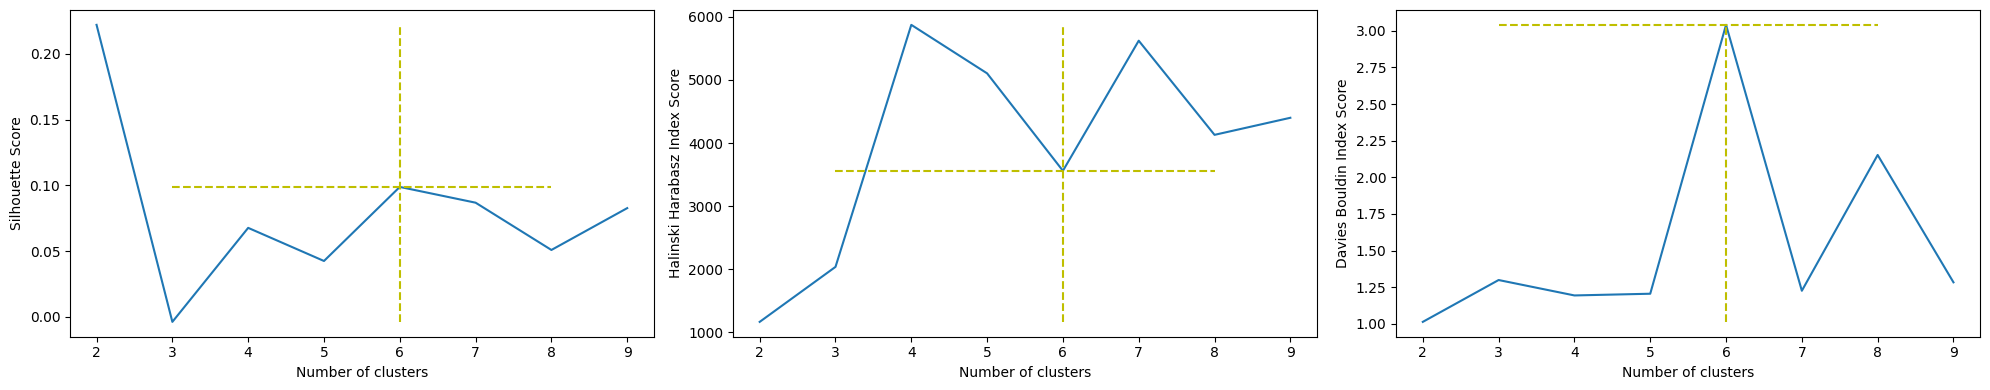

In [ ]:
plot_GMM_sc = pd.DataFrame.from_dict(GMM_scores, orient='index')
num_cluster = 6
fig = plt.subplots(figsize=(20,4))

# PLOT SILHOUETTE SCORE FOR EACH CLUSTERS
plt.subplot(1,3,1)
plt.plot(GMM_clusters, plot_GMM_sc['SS'])
plt.vlines(x=num_cluster,ymax=max(plot_GMM_sc['SS']),ymin=min(plot_GMM_sc['SS']),color='y',linestyles='--')
plt.hlines(y=0.09878901036187258,xmax=8,xmin=3,color='y',linestyles='--')
plt.ylabel("Silhouette Score")
plt.xlabel("Number of clusters")

# PLOT HALINSKI HARABASZ INDEX FOR EACH CLUSTERS
plt.subplot(1,3,2)
plt.plot(GMM_clusters, plot_GMM_sc['CKI'])
plt.vlines(x=num_cluster,ymax=max(plot_GMM_sc['CKI']),ymin=min(plot_GMM_sc['CKI']),color='y',linestyles='--')
plt.hlines(y=3560.785520707249,xmax=8,xmin=3,color='y',linestyles='--')
plt.ylabel("Halinski Harabasz Index Score")
plt.xlabel("Number of clusters")

# PLOT DAVIES BOULDIN INDEX FOR EACH CLUSTERS
plt.subplot(1,3,3)
plt.plot(GMM_clusters, plot_GMM_sc['DBI'])
plt.vlines(x=num_cluster,ymax=max(plot_GMM_sc['DBI']),ymin=min(plot_GMM_sc['DBI']),color='y',linestyles='--')
plt.hlines(y=3.0409748867136073,xmax=8,xmin=3,color='y',linestyles='--')
plt.ylabel("Davies Bouldin Index Score")
plt.xlabel("Number of clusters")

plt.tight_layout()
plt.show()

- GMM Final Model

With Number of clusters = 6

In [ ]:
gmm = GaussianMixture(n_components=6, random_state=123)
gmm.fit(X_pca)
gmm_labels = gmm.predict(X_pca)
DF_X_pca ['GMM_cluster_ID'] = gmm_labels
X ['GMM_cluster_ID'] = gmm_labels

- GMM Plot clusters

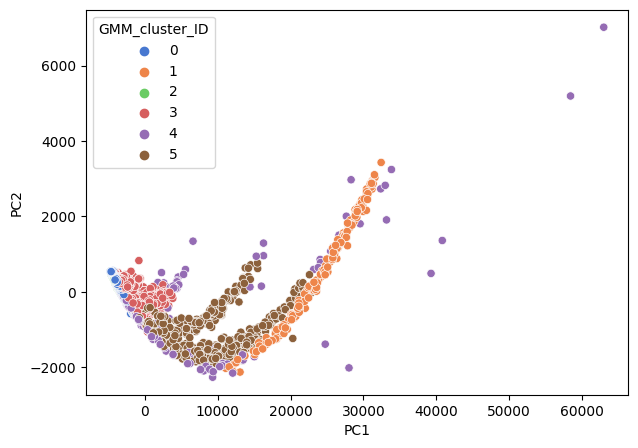

In [ ]:
fig = plt.figure(figsize=[7,5],dpi=100)
sns.scatterplot(x='PC1',y='PC2',data=DF_X_pca,hue='GMM_cluster_ID', palette = sns.color_palette("muted"))
plt.show()

- Interpretation and clustering pattern Analysis

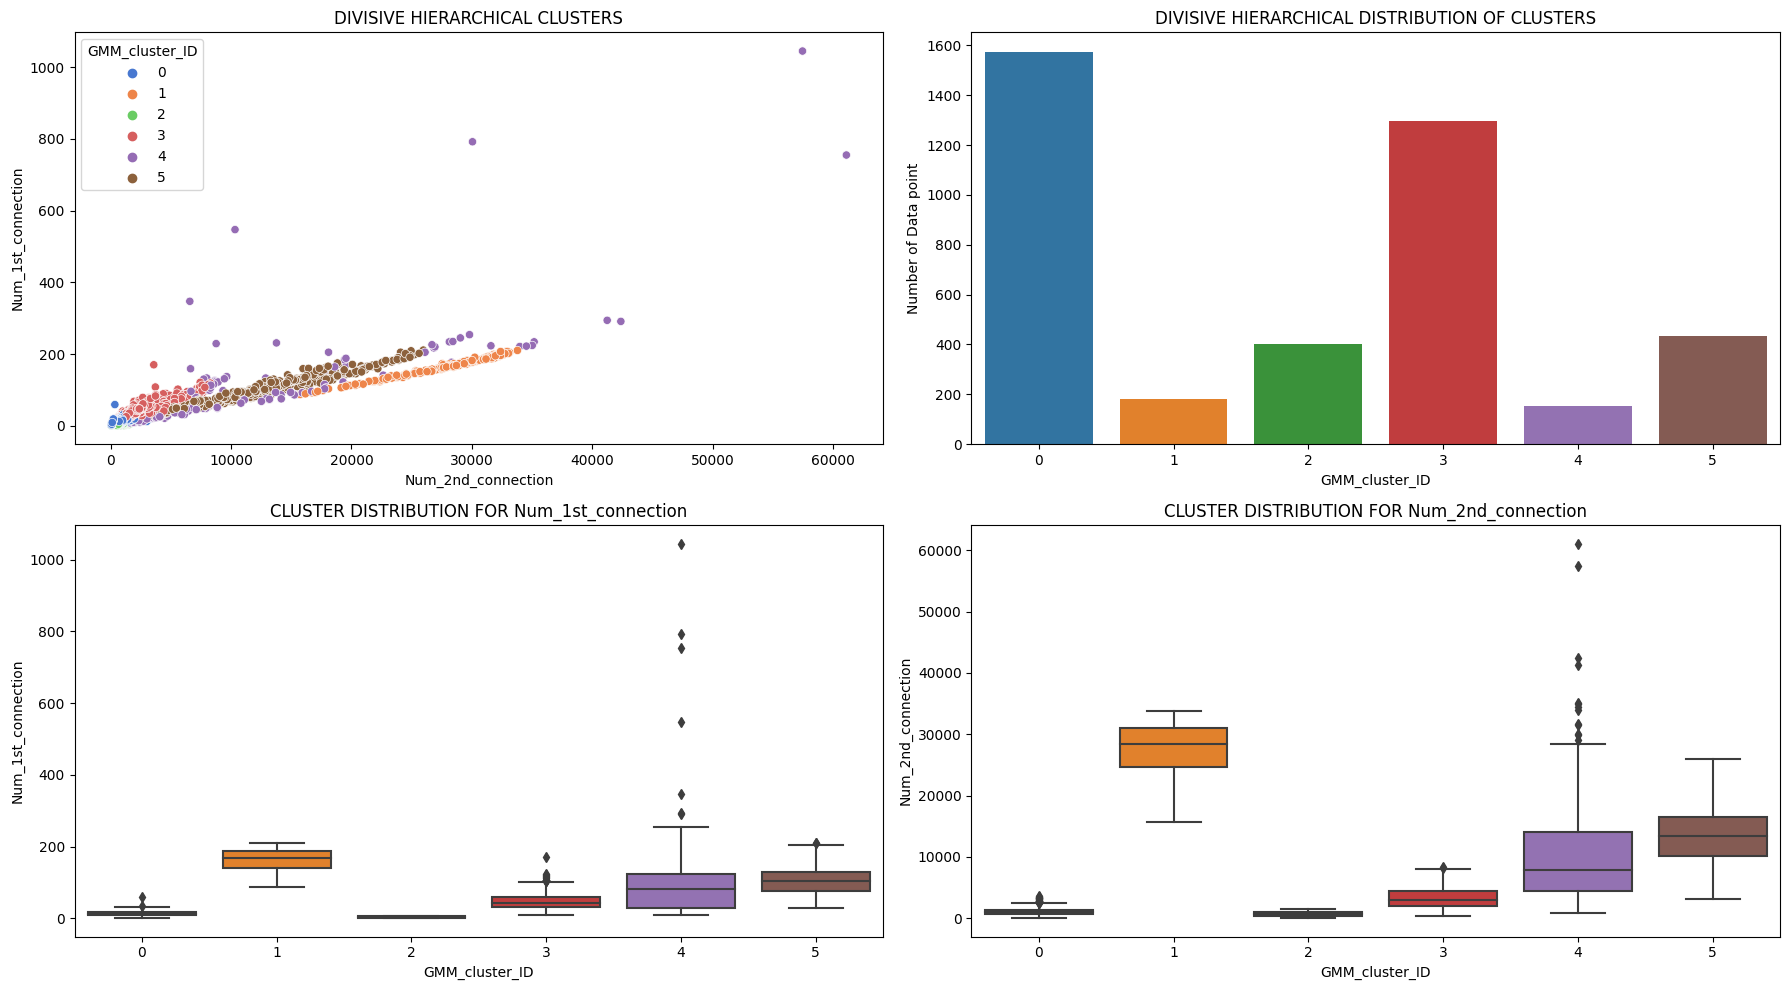

In [ ]:
fig = plt.subplots(figsize=(18,10))

# PLOT AGGLOMERATIVE CLUSTERS USING Num_1st_connection AND Num_2nd_connection

plt.subplot(2,2,1)
sns.scatterplot(x='Num_2nd_connection',y='Num_1st_connection',data=X,hue='GMM_cluster_ID',palette = sns.color_palette("muted"))
plt.title('DIVISIVE HIERARCHICAL CLUSTERS')

# PLOT THE CLUSTER DISTRIBUTION
plt.subplot(2,2,2)
sns.countplot(X, x=X['GMM_cluster_ID'])
plt.ylabel("Number of Data point")
plt.title('DIVISIVE HIERARCHICAL DISTRIBUTION OF CLUSTERS')

# PLOT THE CLUSTER DISTRIBUTION
plt.subplot(2,2,3)
sns.boxplot(y=X["Num_1st_connection"],x=X["GMM_cluster_ID"])
plt.title('CLUSTER DISTRIBUTION FOR Num_1st_connection')

# PLOT THE CLUSTER DISTRIBUTION
plt.subplot(2,2,4)
sns.boxplot(y=X["Num_2nd_connection"],x=X["GMM_cluster_ID"])
plt.title('CLUSTER DISTRIBUTION FOR Num_2nd_connection')

plt.tight_layout()
plt.show()

### 6.7 DBSCAN Clustering

density-based spatial clustering of applications with noise. It is able to find arbitrary shaped clusters and clusters with noise

- Evaluation, Refinement and Iteration

There are two main parameters:

epsilon: The distance that specifies the neighborhoods. Two points are neighbors if the distance between them is less than or equal to eps.

Min_sample: Minimum number of data points to define a cluster

In [ ]:
eps_value = [0.5, 10.0, 180.0, 350.0, 500.0]
min_sample_size = [8, 10 ,12, 13, 14]
DBSCAN_score = {}

for ev in eps_value:
  for mss in min_sample_size:
    dbscan = DBSCAN(eps=ev, min_samples=mss).fit(X_pca)
    cluster = len(np.unique(dbscan.labels_))
    sil_score = silhouette_score(X_pca, dbscan.labels_)
    calinski_harabasz_index = calinski_harabasz_score(X_pca, dbscan.labels_)
    davies_bouldin_index = davies_bouldin_score(X_pca, dbscan.labels_)
    print(f"eps: {ev}, min_sample: {mss}, clusters: {cluster}, SS: {sil_score}, CKI= {calinski_harabasz_index}, DBI= {davies_bouldin_index}")
    DBSCAN_score[(ev, mss)] = {'MSS': mss, 'C': cluster,'SS': sil_score, 'CKI' : calinski_harabasz_index, 'DBI' : davies_bouldin_index}

eps: 0.5, min_sample: 8, clusters: 5, SS: -0.4690999529272044, CKI= 4.158286013883276, DBI= 1.1177418605176428
eps: 0.5, min_sample: 10, clusters: 4, SS: -0.4639082299992115, CKI= 4.368562604454156, DBI= 1.1334476721809703
eps: 0.5, min_sample: 12, clusters: 3, SS: -0.46147705833858466, CKI= 4.748108351998408, DBI= 1.1171796982509605
eps: 0.5, min_sample: 13, clusters: 3, SS: -0.46147705833858466, CKI= 4.748108351998408, DBI= 1.1171796982509605
eps: 0.5, min_sample: 14, clusters: 2, SS: -0.46034625459690826, CKI= 5.031418347793643, DBI= 1.0987589246491805
eps: 10.0, min_sample: 8, clusters: 15, SS: -0.5204626612697878, CKI= 4.16925638145082, DBI= 1.1191365842280814
eps: 10.0, min_sample: 10, clusters: 8, SS: -0.5417657118469401, CKI= 4.5609680980797425, DBI= 1.1601719585536503
eps: 10.0, min_sample: 12, clusters: 4, SS: -0.4802181220137271, CKI= 5.688756432343882, DBI= 1.112153331414725
eps: 10.0, min_sample: 13, clusters: 4, SS: -0.4802181220137271, CKI= 5.688756432343882, DBI= 1.1121

- Plot evaluation metrics

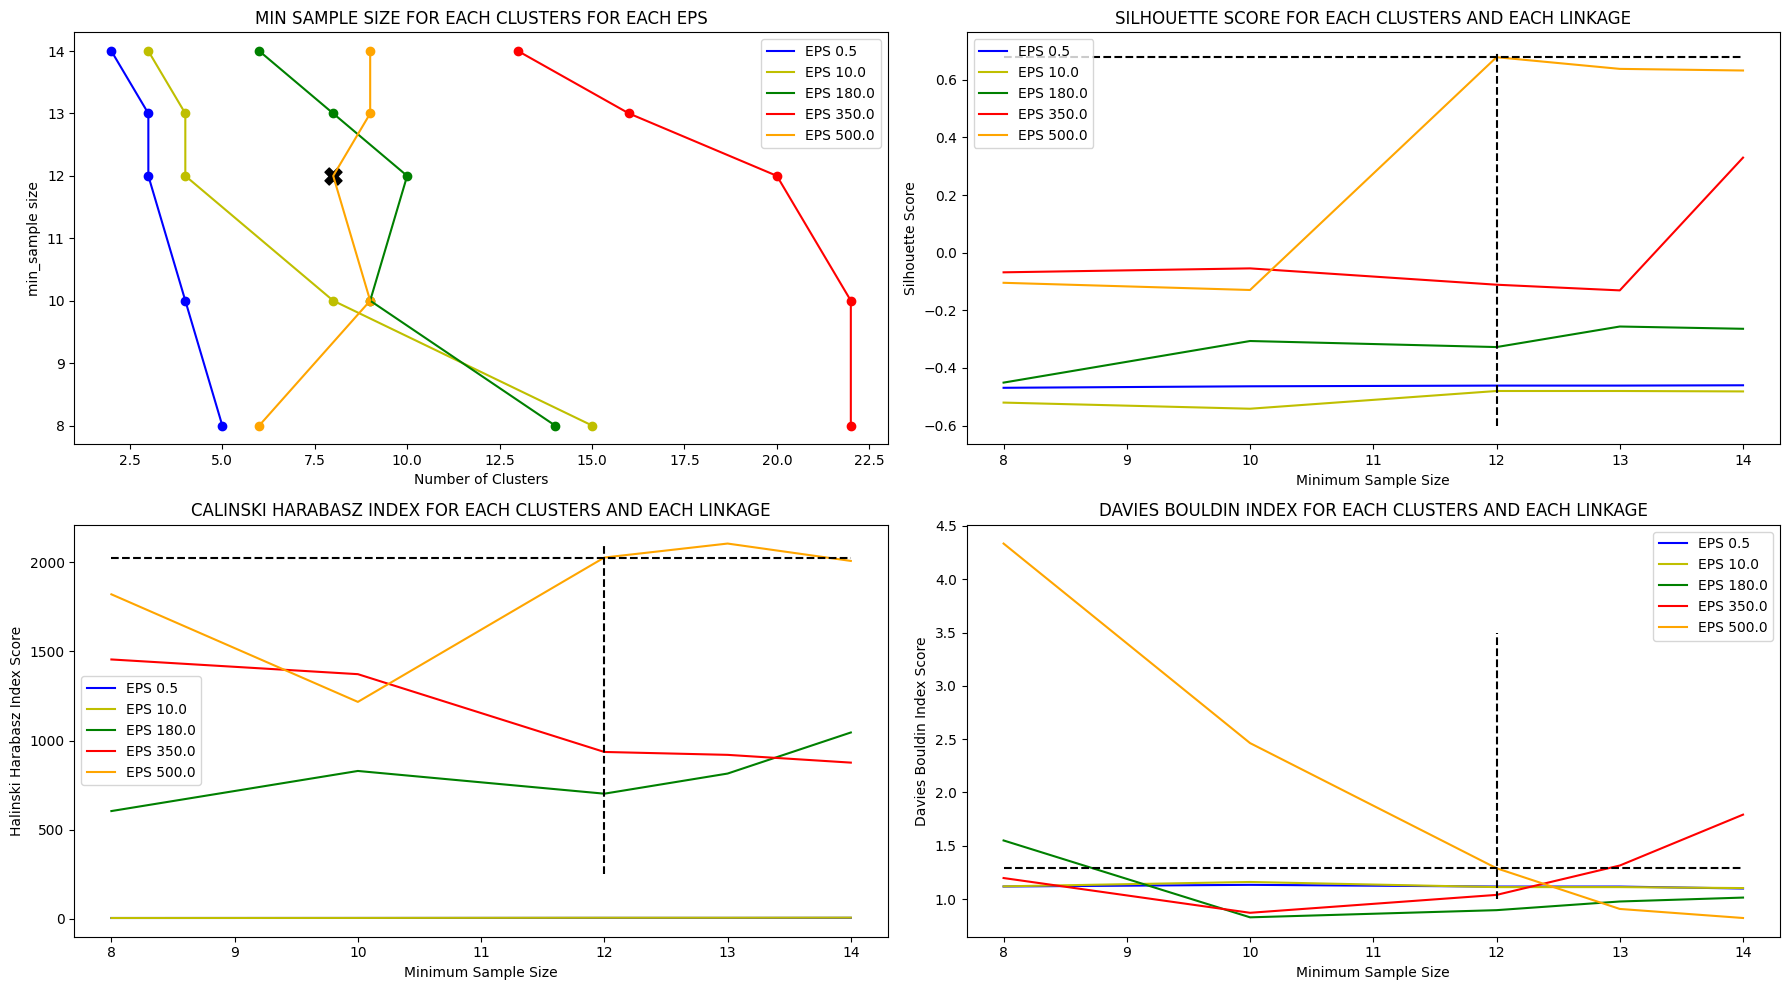

In [ ]:
# PLOT PERFORMANCE SCORE FOR DBSCAN
plot_DBSCAN_sc = pd.DataFrame.from_dict(DBSCAN_score, orient='index')
fig = plt.subplots(figsize=(18,10))
DBCSAN_clusters = [2,6,12,18,24]

# PLOT MIN SAMPLE SIZE FOR EACH CLUSTERS FOR EACH EPS
plt.subplot(2,2,1)
plt.scatter(plot_DBSCAN_sc['C'].loc[0.5],plot_DBSCAN_sc['MSS'].loc[0.5],c='b')
plt.scatter(plot_DBSCAN_sc['C'].loc[10.0],plot_DBSCAN_sc['MSS'].loc[10.0],c='y')
plt.scatter(plot_DBSCAN_sc['C'].loc[180.0],plot_DBSCAN_sc['MSS'].loc[180.0],c='g')
plt.scatter(plot_DBSCAN_sc['C'].loc[350.0],plot_DBSCAN_sc['MSS'].loc[350.0],c='r')
plt.scatter(plot_DBSCAN_sc['C'].loc[500.0],plot_DBSCAN_sc['MSS'].loc[500.0],color='orange')
plt.plot(plot_DBSCAN_sc['C'].loc[0.5],plot_DBSCAN_sc['MSS'].loc[0.5],c='b',label='EPS 0.5')
plt.plot(plot_DBSCAN_sc['C'].loc[10.0],plot_DBSCAN_sc['MSS'].loc[10.0],c='y',label='EPS 10.0')
plt.plot(plot_DBSCAN_sc['C'].loc[180.0],plot_DBSCAN_sc['MSS'].loc[180.0],c='g',label='EPS 180.0')
plt.plot(plot_DBSCAN_sc['C'].loc[350.0],plot_DBSCAN_sc['MSS'].loc[350.0],c='r',label='EPS 350.0')
plt.plot(plot_DBSCAN_sc['C'].loc[500.0],plot_DBSCAN_sc['MSS'].loc[500.0],color='orange',label='EPS 500.0')
plt.scatter(8,12,color='black',marker="X",s=150)
plt.legend()
plt.title('MIN SAMPLE SIZE FOR EACH CLUSTERS FOR EACH EPS')
plt.ylabel("min_sample size")
plt.xlabel("Number of Clusters")

# PLOT SILHOUETTE SCORE FOR EACH CLUSTERS AND EACH LINKAGE
plt.subplot(2,2,2)
plt.plot(plot_DBSCAN_sc['MSS'].loc[0.5],plot_DBSCAN_sc['SS'].loc[0.5],c='b',label='EPS 0.5')
plt.plot(plot_DBSCAN_sc['MSS'].loc[10.0],plot_DBSCAN_sc['SS'].loc[10.0],c='y',label='EPS 10.0')
plt.plot(plot_DBSCAN_sc['MSS'].loc[180.0],plot_DBSCAN_sc['SS'].loc[180.0],c='g',label='EPS 180.0')
plt.plot(plot_DBSCAN_sc['MSS'].loc[350.0],plot_DBSCAN_sc['SS'].loc[350.0],c='r',label='EPS 350.0')
plt.plot(plot_DBSCAN_sc['MSS'].loc[500.0],plot_DBSCAN_sc['SS'].loc[500.0],color='orange',label='EPS 500.0')
plt.vlines(x=12,ymax=.7,ymin=-0.6,color='black',linestyles='--')
plt.hlines(y=0.678669452377309,xmax=max(min_sample_size),xmin=min(min_sample_size),color='black',linestyles='--')
plt.legend()
plt.title('SILHOUETTE SCORE FOR EACH CLUSTERS AND EACH LINKAGE')
plt.ylabel("Silhouette Score")
plt.xlabel("Minimum Sample Size")

# PLOT CALINSKI HARABASZ INDEX FOR EACH CLUSTERS AND EACH LINKAGE
plt.subplot(2,2,3)
plt.plot(plot_DBSCAN_sc['MSS'].loc[0.5],plot_DBSCAN_sc['CKI'].loc[0.5],c='b',label='EPS 0.5')
plt.plot(plot_DBSCAN_sc['MSS'].loc[10.0],plot_DBSCAN_sc['CKI'].loc[10.0],c='y',label='EPS 10.0')
plt.plot(plot_DBSCAN_sc['MSS'].loc[180.0],plot_DBSCAN_sc['CKI'].loc[180.0],c='g',label='EPS 180.0')
plt.plot(plot_DBSCAN_sc['MSS'].loc[350.0],plot_DBSCAN_sc['CKI'].loc[350.0],c='r',label='EPS 350.0')
plt.plot(plot_DBSCAN_sc['MSS'].loc[500.0],plot_DBSCAN_sc['CKI'].loc[500.0],color='orange',label='EPS 500.0')
plt.vlines(x=12,ymax=2100,ymin=250,color='black',linestyles='--')
plt.hlines(y=2027.2544755737079,xmax=max(min_sample_size),xmin=min(min_sample_size),color='black',linestyles='--')
plt.legend()
plt.title('CALINSKI HARABASZ INDEX FOR EACH CLUSTERS AND EACH LINKAGE')
plt.ylabel("Halinski Harabasz Index Score")
plt.xlabel("Minimum Sample Size")

# PLOT DAVIES BOULDIN INDEX FOR EACH CLUSTERS AND EACH LINKAGE
plt.subplot(2,2,4)
plt.plot(plot_DBSCAN_sc['MSS'].loc[0.5],plot_DBSCAN_sc['DBI'].loc[0.5],c='b',label='EPS 0.5')
plt.plot(plot_DBSCAN_sc['MSS'].loc[10.0],plot_DBSCAN_sc['DBI'].loc[10.0],c='y',label='EPS 10.0')
plt.plot(plot_DBSCAN_sc['MSS'].loc[180.0],plot_DBSCAN_sc['DBI'].loc[180.0],c='g',label='EPS 180.0')
plt.plot(plot_DBSCAN_sc['MSS'].loc[350.0],plot_DBSCAN_sc['DBI'].loc[350.0],c='r',label='EPS 350.0')
plt.plot(plot_DBSCAN_sc['MSS'].loc[500.0],plot_DBSCAN_sc['DBI'].loc[500.0],color='orange',label='EPS 500.0')
plt.vlines(x=12,ymax=3.5,ymin=1,color='black',linestyles='--')
plt.hlines(y=1.2889211849124522,xmax=max(min_sample_size),xmin=min(min_sample_size),color='black',linestyles='--')
plt.legend()
plt.title('DAVIES BOULDIN INDEX FOR EACH CLUSTERS AND EACH LINKAGE')
plt.ylabel("Davies Bouldin Index Score")
plt.xlabel("Minimum Sample Size")

plt.tight_layout()
plt.show()

- DBSCAN Final Model

With Min_Sample = 12 and EPS = 500

In [ ]:
dbscan = DBSCAN(eps=500, min_samples=12)
dbscan.fit(X_pca)
DF_X_pca ['DBSCAN_cluster_ID'] = dbscan.labels_
X ['DBSCAN_cluster_ID'] = dbscan.labels_

- DBSCAN Plot clusters

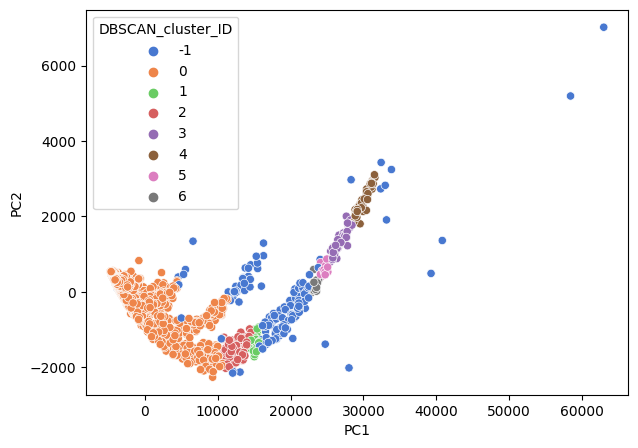

In [ ]:
# PLOT DBSCAN CLUSTERING USING PC1 AND PC2
fig = plt.figure(figsize=[7,5],dpi=100)
sns.scatterplot(x='PC1',y='PC2',data=DF_X_pca,hue='DBSCAN_cluster_ID',palette = sns.color_palette("muted"))
plt.show()

- Interpretation and clustering pattern Analysis

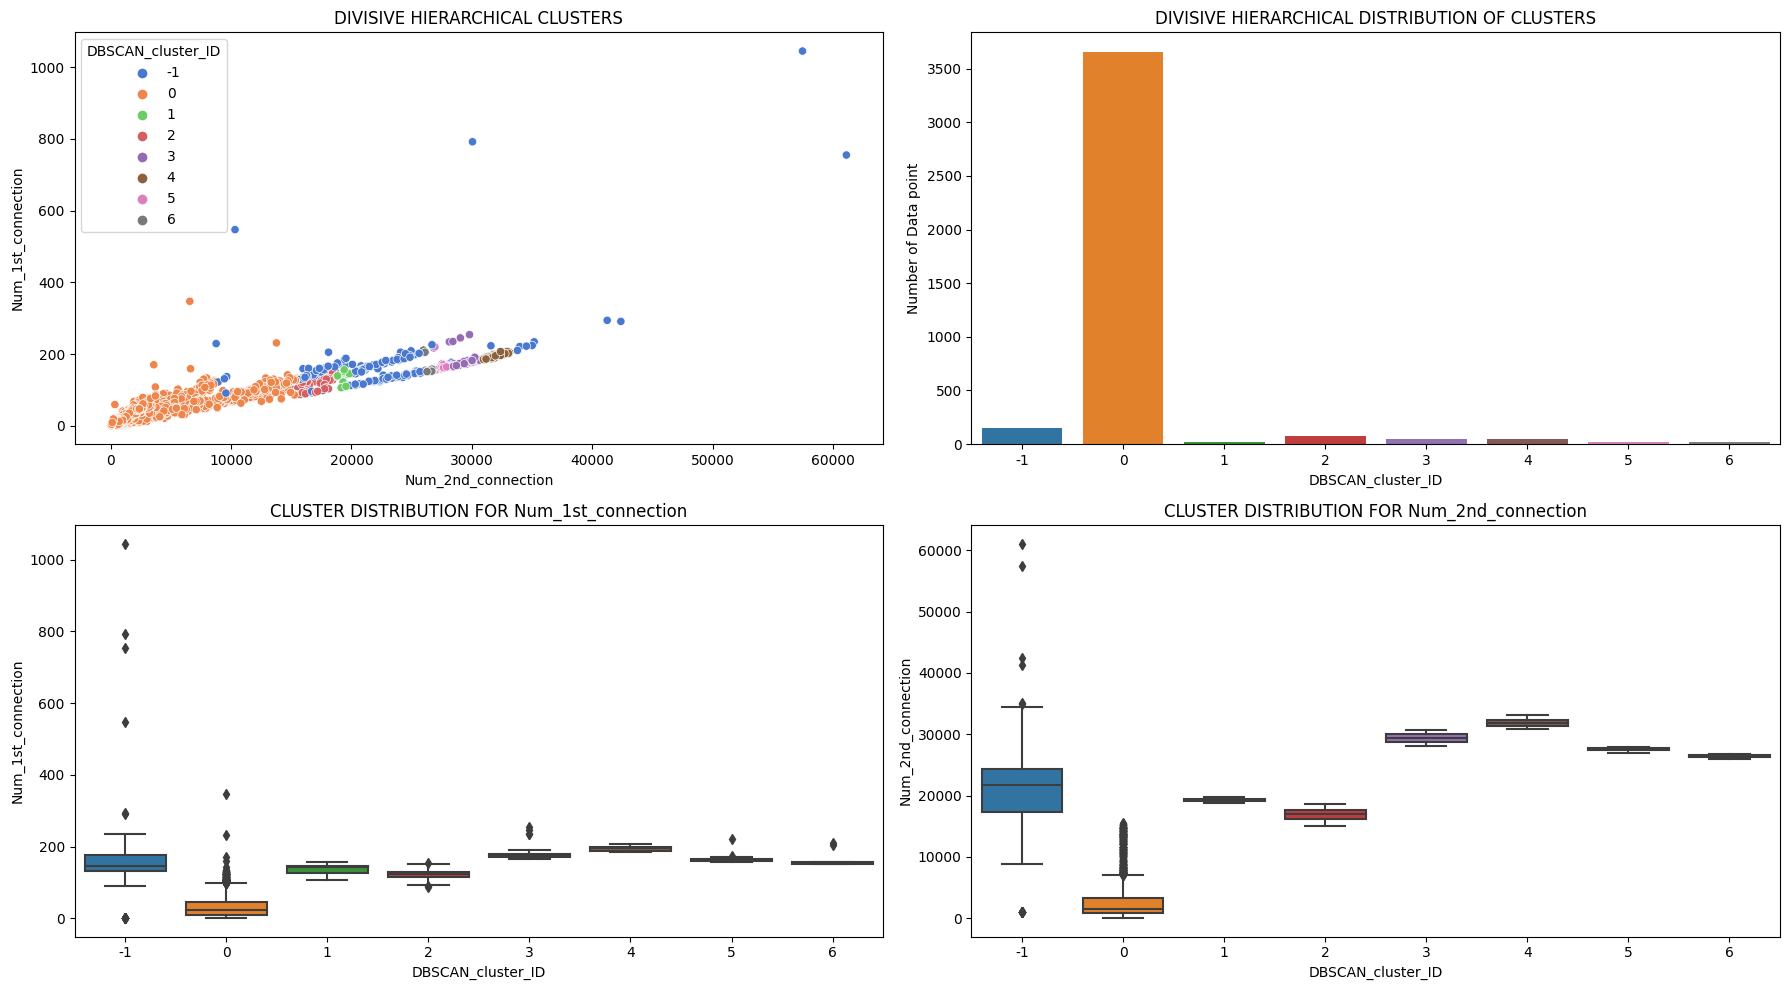

In [ ]:
fig = plt.subplots(figsize=(18,10))

# PLOT DBSCAN CLUSTERS USING Num_1st_connection AND Num_2nd_connection

plt.subplot(2,2,1)
sns.scatterplot(x='Num_2nd_connection',y='Num_1st_connection',data=X,hue='DBSCAN_cluster_ID',palette = sns.color_palette("muted"))
plt.title('DIVISIVE HIERARCHICAL CLUSTERS')

# PLOT THE CLUSTER DISTRIBUTION
plt.subplot(2,2,2)
sns.countplot(X, x=X['DBSCAN_cluster_ID'])
plt.ylabel("Number of Data point")
plt.title('DIVISIVE HIERARCHICAL DISTRIBUTION OF CLUSTERS')

# PLOT THE CLUSTER DISTRIBUTION
plt.subplot(2,2,3)
sns.boxplot(y=X["Num_1st_connection"],x=X["DBSCAN_cluster_ID"])
plt.title('CLUSTER DISTRIBUTION FOR Num_1st_connection')

# PLOT THE CLUSTER DISTRIBUTION
plt.subplot(2,2,4)
sns.boxplot(y=X["Num_2nd_connection"],x=X["DBSCAN_cluster_ID"])
plt.title('CLUSTER DISTRIBUTION FOR Num_2nd_connection')

plt.tight_layout()
plt.show()

## 7 Outliers / Anomaly Detection and Analysis

- Using Z-Score on X_pca Data and not on train data (X)

TOTAL NUMBER OF DATA POINT INCLUDING OUTLIERS:  4039


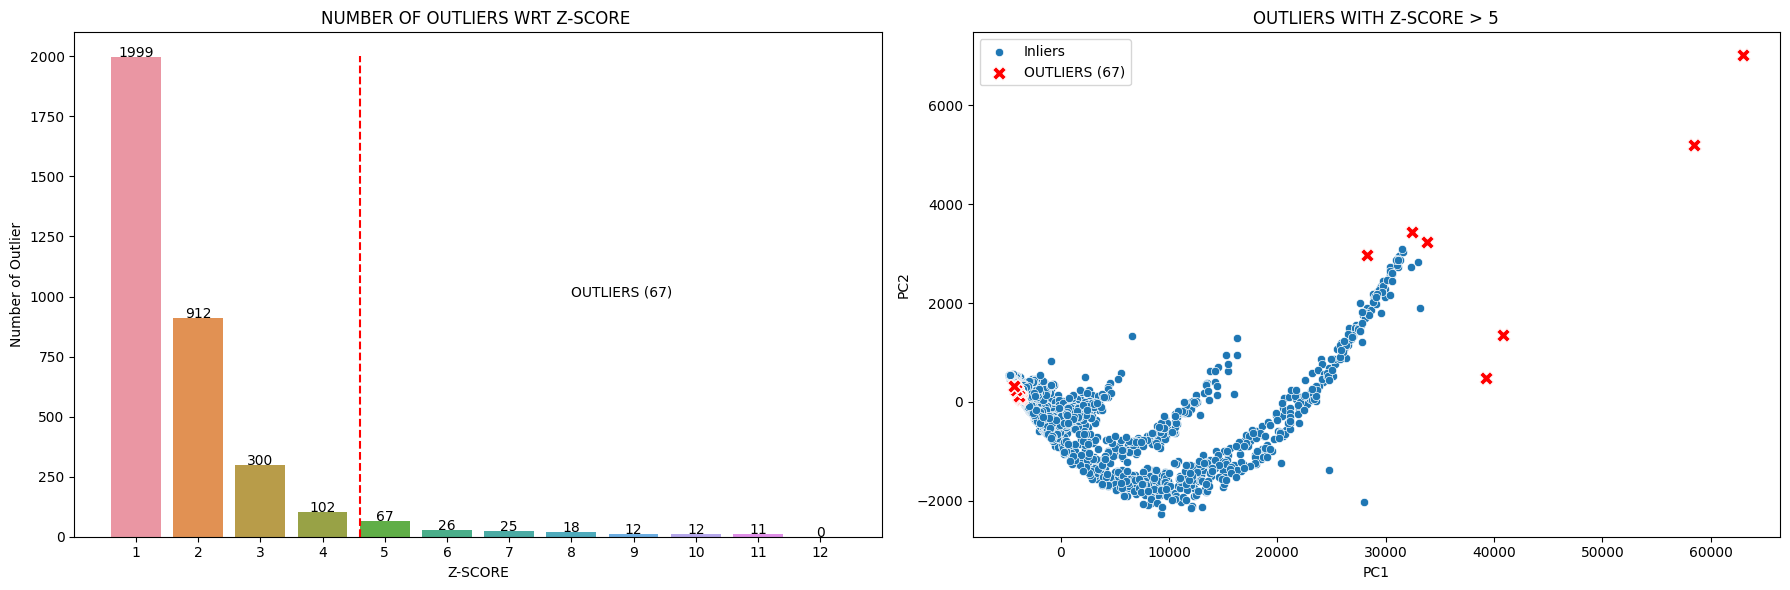

In [ ]:
z_score = np.array(range(1,13))
print("TOTAL NUMBER OF DATA POINT INCLUDING OUTLIERS: ", X_pca.shape[0])
z_outliers = {}

for zs in z_score:
    z = np.abs(stats.zscore(X_pca)) # Calculate Z-Scores
    outliers = np.where(z > zs)
    z_outliers[zs] = {'no_outliers' : len(np.unique(outliers[0])), 'outliers_indices' : np.unique(outliers[0])}
df_z_outliers = pd.DataFrame.from_dict(z_outliers, orient='index')
df_z_outliers.index.names = ['zscore']

fig = plt.subplots(figsize=(18,6))

# PLOT THE NUMBER OF OUTLIERS WRT Z-SCORE
plt.subplot(1,2,1)

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

x = z_score # Z-Score
y = df_z_outliers['no_outliers'].tolist() # NUMBER OF OUTLIERS

sns.barplot(x=x,y=y)
plt.vlines(x=3.6,ymax=2000,ymin=0,color='r',linestyles='--')
o_count = "OUTLIERS (" + str(y[4])+")"
plt.text(7,1000,o_count)
plt.ylabel("Number of Outlier")
plt.xlabel("Z-SCORE")
plt.title("NUMBER OF OUTLIERS WRT Z-SCORE ")
addlabels(x, y)

# PLOT THE OUTLIERS WITH Z-SCORE > 5
z_score = 5
plt.subplot(1,2,2)
outliers_list = df_z_outliers.loc[z_score]['outliers_indices'].tolist()
outliers = "OUTLIERS (" + str(df_z_outliers.loc[z_score]['no_outliers']) + ")"
sns.scatterplot(x='PC1',y='PC2',data=DF_X_pca,label='Inliers',palette = sns.color_palette("muted"))
sns.scatterplot(x='PC1',y='PC2',data=DF_X_pca.loc[outliers_list],label=outliers ,marker="X",facecolor="r",s=100)
plt.title("OUTLIERS WITH Z-SCORE > " + str(z_score))

plt.tight_layout()
plt.show()

- Using K-MEANS cluster center and Pair-wise distance

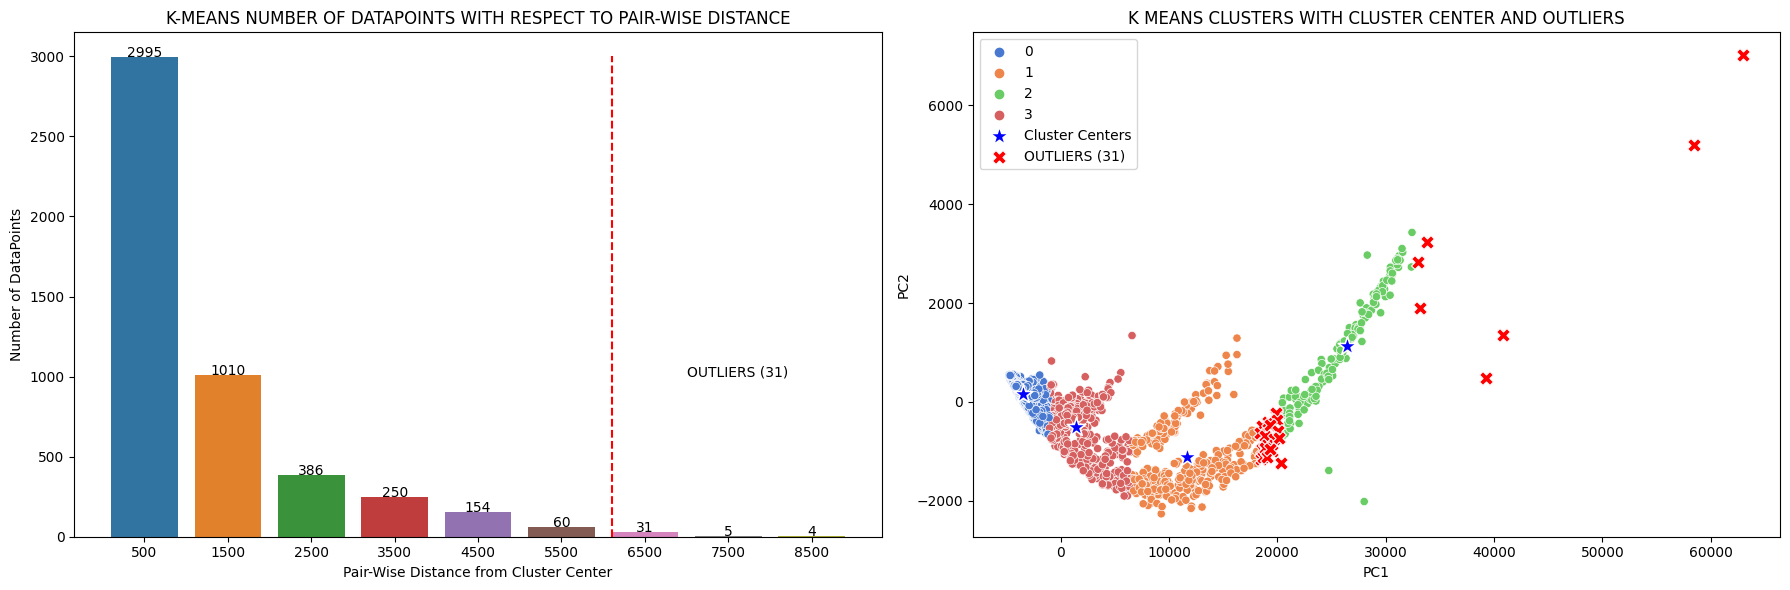

In [ ]:
# CALCULATE K-MEANS PAIR-WISE DISTANCE FOR EACH DATAPOINTS FROM CLUSTER CENTER
centers = kmeans.cluster_centers_
distances = pairwise_distances_argmin_min(X_pca, centers)[1]

# TRY TO FIND DISTANCE TRASHOLD AND NUMBER OF OUTLIER DATAPOINTS OUTSIDE OF THRASHOLD
#  Indices:-         0     1     2     3     4     5     6     7     8
dist_thresholds = [500, 1500, 2500, 3500, 4500, 5500, 6500, 7500, 8500]
outlier = []
outliers_labels = []
outliers_count = []
for i in range(0, len(dist_thresholds)):
    is_outliers = distances > dist_thresholds[i]
    outliers_labels.append(is_outliers.astype(int))
    outliers_count.append(outliers_labels[i].sum())
    outlier.append([i, dist_thresholds[i], outliers_count[i]])
outlier_array =np.array(outlier)

fig = plt.subplots(figsize=(18,6))

# # PLOT THE NUMBER OF DATAPOINTS WITH RESPECT TO PAIR-WISE DISTANCE
plt.subplot(1,2,1)
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')
x = outlier_array[:,1] # THRASHOLD VALUE
y = outlier_array[:,2] # NUMBER OF DATA POINTS
sns.barplot(x=x,y=y)
plt.vlines(x=5.6,ymax=3000,ymin=0,color='r',linestyles='--')
o_count = "OUTLIERS (" + str(outliers_count[6])+")"
plt.text(6.5,1000,o_count)
plt.ylabel("Number of DataPoints")
plt.xlabel("Pair-Wise Distance from Cluster Center")
plt.title("K-MEANS NUMBER OF DATAPOINTS WITH RESPECT TO PAIR-WISE DISTANCE")
addlabels(x, y)


# PLOT THE OUTLIERS
# SET THE DISTANCE TRASHOLD TO 6500 WTIH 31 OUTLIER DATA POINTS[WHICH IS INDEX 6]. ADD THEM TO DF
index = 6
DF_X_pca['K_Means_Outlier'] = outliers_labels[index]

plt.subplot(1,2,2)
sns.scatterplot(x='PC1',y='PC2',data=DF_X_pca,hue='K_Means_cluster_ID',palette = sns.color_palette("muted"))
sns.scatterplot(x=centers[:,0],y=centers[:,1],label="Cluster Centers" ,marker="*",facecolor="b",s=200)
sns.scatterplot(x='PC1',y='PC2',data=DF_X_pca[DF_X_pca['K_Means_Outlier'] == 1],label=o_count ,marker="X",facecolor="r",s=100)
plt.title('K MEANS CLUSTERS WITH CLUSTER CENTER AND OUTLIERS')

plt.tight_layout()
plt.show()

- Using Local Outlier Factor Model

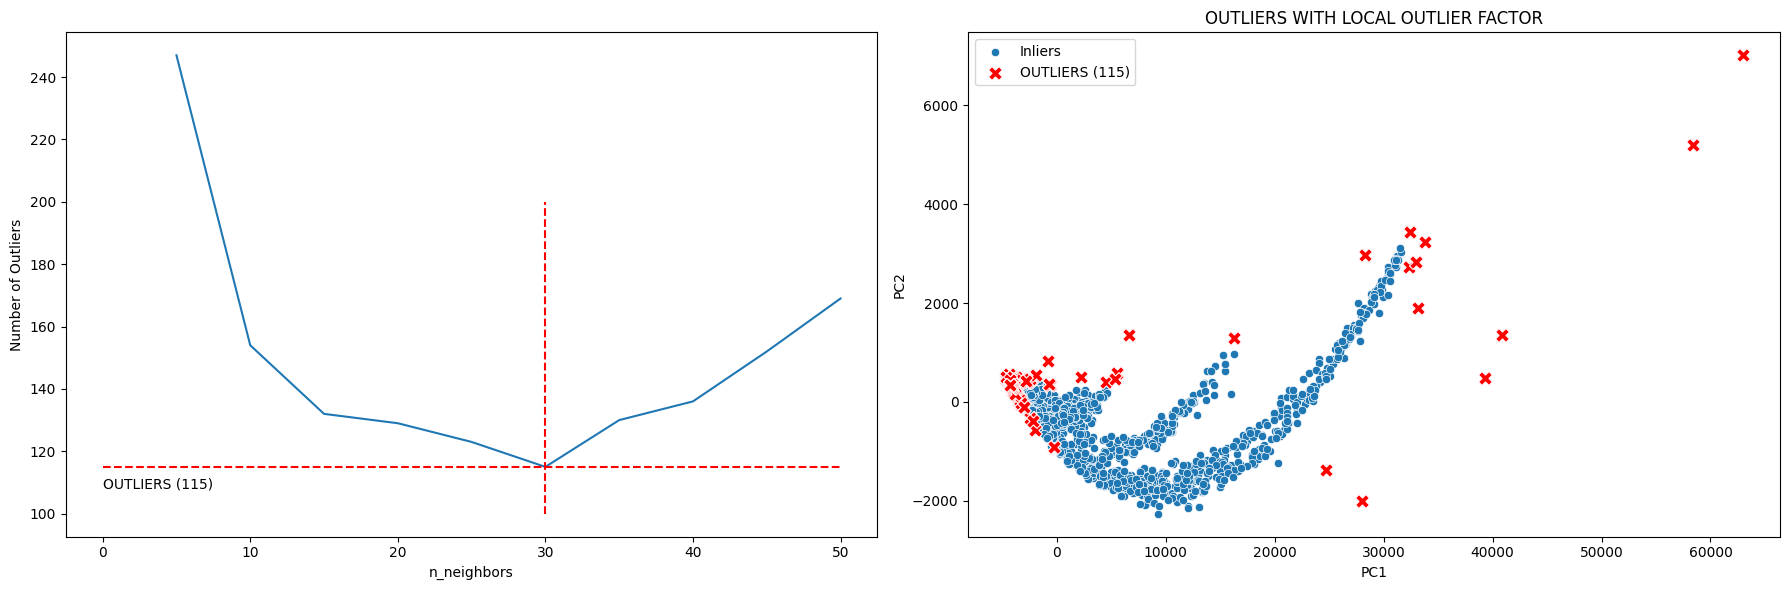

In [ ]:
# FIND OPTIMUM NUMBER OF n_neighbors
# Indices:-      0   1   2   3   4   5   6   7   8   9
num_neighbors = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
LOF_outliers = []
outliers_points = []
outliers_count = []

for i in range (0, len(num_neighbors)):
    lof = LocalOutlierFactor(n_neighbors=num_neighbors[i])
    outliers_points.append(lof.fit_predict(X_pca))
    outliers_count.append(np.sum(outliers_points[i] == -1))
    LOF_outliers.append([num_neighbors[i], outliers_count[i]])
LOF_outliers_array = np.array(LOF_outliers)

fig = plt.subplots(figsize=(18,6))

# PLOT AND FIND BEST n_neighbors WITH MIN NUMBER OF CLUSTERS
plt.subplot(1,2,1)
plt.plot(num_neighbors,LOF_outliers_array[:,1])
plt.vlines(x=30,ymax=200,ymin=100,color='red',linestyles='--')
plt.hlines(y=outliers_count[5],xmax=50,xmin=0,color='red',linestyles='--')
o_count = "OUTLIERS (" + str(outliers_count[5])+")"
plt.text(0,108, o_count)
plt.ylabel("Number of Outliers")
plt.xlabel("n_neighbors")

# SET THE n_neighbors = 30 TO GET 115 CLUSTERS
DF_X_pca['LOF_outliers'] = outliers_points[5] # INDEX 5 FOR 30
X['LOF_outliers'] = outliers_points[5] # INDEX 5 FOR 30

# PLOT LOCAL OUTLIERS
plt.subplot(1,2,2)
outliers = "OUTLIERS (" + str((DF_X_pca[DF_X_pca['LOF_outliers']==-1].count()['PC1'])) + ")"
sns.scatterplot(x='PC1',y='PC2',data=DF_X_pca[DF_X_pca['LOF_outliers'] != -1],label='Inliers',palette = sns.color_palette("muted"))
sns.scatterplot(x='PC1',y='PC2',data=DF_X_pca[DF_X_pca['LOF_outliers'] == -1],label=outliers ,marker="X",facecolor="r",s=100)
plt.title("OUTLIERS WITH LOCAL OUTLIER FACTOR")

plt.tight_layout()
plt.show()

- Using DBSCAN clusters

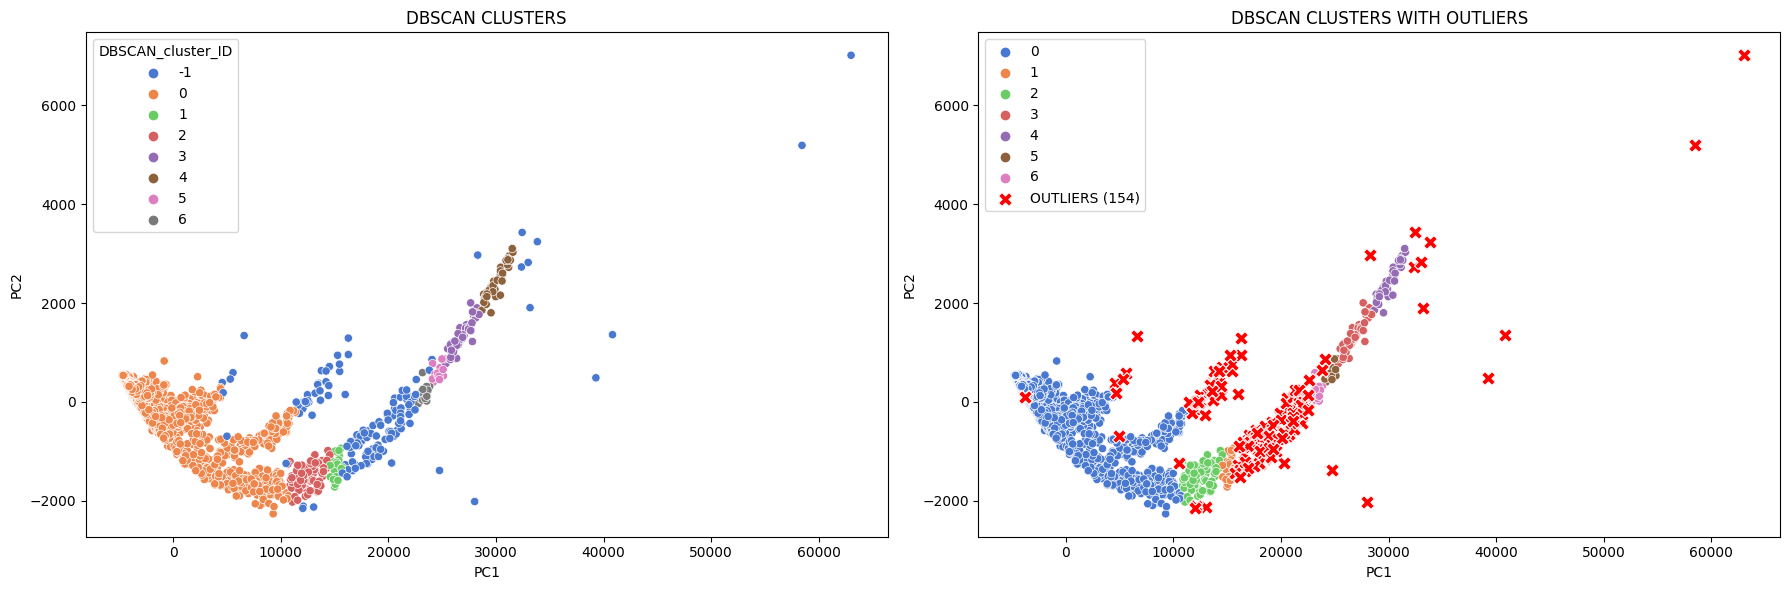

In [ ]:
fig = plt.subplots(figsize=(18,6))

# PLOT DBSCAN CLUSTERS
plt.subplot(1,2,1)
sns.scatterplot(x='PC1',y='PC2',data=DF_X_pca,hue='DBSCAN_cluster_ID',palette = sns.color_palette("muted"))
plt.title("DBSCAN CLUSTERS")

# PLOT OUTLIERS FROM DBSCAN CLUSTERS GROUP -1 IS OUTLIERS
plt.subplot(1,2,2)
outliers = "OUTLIERS (" + str((DF_X_pca[DF_X_pca['DBSCAN_cluster_ID']==-1].count()['PC1'])) + ")"
sns.scatterplot(x='PC1',y='PC2',data=DF_X_pca[DF_X_pca['DBSCAN_cluster_ID'] != -1],hue='DBSCAN_cluster_ID',palette = sns.color_palette("muted"))
sns.scatterplot(x='PC1',y='PC2',data=DF_X_pca[DF_X_pca['DBSCAN_cluster_ID'] == -1],label=outliers ,marker="X",facecolor="r",s=100)
plt.title("DBSCAN CLUSTERS WITH OUTLIERS")

plt.tight_layout()
plt.show()

## 8 Reporting and Conclusion on clustering models

As part of my analysis, I compared the clusters created by different types of unsupervised clustering models.

#### K-Means Interpretation:

Based on the different evaluation matrices, I decided to group the data with 4 clusters and Silhouette Score above .68 (which is classified as good score for a model). Even the other matrices gave good indicator for 4 clusters.

When plotting these clusters on the PCA and training (X) data, it created a beautiful separation of datapoints into four different clusters. While observing close into the plot on training data (X) the clustering groupings were done as follows:

    group 0: low number of 2nd connections
    group 1: high number of 2nd connections
    group 2: very-high number of 2nd connections
    group 3: moderate number of 2nd connections

To me, K-Means could be one of the best clustering models for the given data.

#### Affinity Propagation Interpretation:

After multiple iteration on tuning Affinity propagation model did not give me a good grouping of the clusters. I was able group the data into 3 clusters, but they were not the best representation of the datapoints. The next best model was with 60 clusters, these are too many cluster groups and not interpreted well in this context.

Affinity Propagation model is not suitable model in this context for given data.

#### Agglomerative (Hierarchical) Interpretation:

For Agglomerative hierarchical clustering, I was able to get some good evaluation matrices for all linkage modes. Every performance scores indicated for 4 number of clusters, but when plotted them against PCA/training data the; groupings were not so great to interpret with very high biasness of one cluster.

To me, Agglomerative is not the best model to represent the data in best possible clusters.

#### Divisive (Hierarchical) Interpretation:

Divisive also was very similar to Agglomerative model, similar scores, and clusters. The plotting indicates the similar groupings and biasness just like agglomerative and is also not considered as the best model to represent the data.

#### BIRCH Interpretation:

BIRCH evaluation matrices were great in all parameters. Every performance matrix indicated for 4 clusters with maximum Silhouette Score above .68 (which is classified as good score for a model). Even the other matrices gave good indicator for 4 clusters.

When plotting these clusters on the PCA and training (X) data, it created a beautiful separation of datapoints into four different clusters. While observing close into the plot on training data (X) the clustering groupings were done as follows:

    group 0: very-high number of 2nd connections
    group 1: low number of 2nd connections
    group 2: high number of 2nd connections
    group 3: moderate number of 2nd connections

BIRCH could be another best clustering model for the given data.

#### Gaussian Mixture Models Interpretation:

On multiple iteration on number of clusters, Gaussian Mixture Models did not give any good performance matrices, which means the model could not generate good group of clusters to represent the datapoints. The maximum Silhouette Score achieved was 0.098 (which is very low for any model with cluster overlaps) with number of clusters = 6.

Plotting them on PCA and training (X) data also confirms on the overlaps.

Because of the overlaps on the clusters to me, Gaussian Mixture Model is not a suitable model for clustering for the given data.

#### DBSCAN Interpretation:

For DBSCAN model, I was not able to tune it for better score with low epsilon and minimum sample size. Using most of the tuning parameters a Silhouette score comes as negative (which indicate that a sample has been assigned to the wrong cluster).
With epsilon value of 500 and minimum sample size of 12 the model game positive Silhouette score of .67 with 8 clusters with -1 being outliers.

DBSCAN is density-based clustering and when plotted the clusters on PCA and training (X) data it is observed that model classified many datapoints as outliers and they overlap with other clusters group.

To me, DBSCAN model may not be the right choice of clustering the given data.


### Outliers / Anomaly Detection Interpretation:

DBSCAN and Local Outlier Factors did not give good representation of outliers.

However, K-Means cluster center with Pair-wise distance – Gave a good segregation of outliers in the datapoints along with clusters. This model identified 31 outliers in the data which can be interpreted and summarized as extreme number of 1st connections. (around 40 datapoint with 1st connections greater than 250)

In [ ]:
print("MEMBERS HAVE MORE THAN 190 1ST CONNECTIONS: ", X['Num_1st_connection'][X['Num_1st_connection'] > 190].count())
print("MEMBERS HAVE MORE THAN 200 1ST CONNECTIONS: ", X['Num_1st_connection'][X['Num_1st_connection'] > 200].count())
print("MEMBERS HAVE MORE THAN 225 1ST CONNECTIONS: ", X['Num_1st_connection'][X['Num_1st_connection'] > 225].count())

MEMBERS HAVE MORE THAN 190 1ST CONNECTIONS:  67
MEMBERS HAVE MORE THAN 200 1ST CONNECTIONS:  40
MEMBERS HAVE MORE THAN 225 1ST CONNECTIONS:  15


### Conclusion on Model choice

After analysis and plotting the data and clusters created with various models, I kind of concluded that the best model for this data is K-Means and the next best would be BIRCH. Since both these models created clean and nice segregation of data into different clusters. The interpretation of datapoints were much better than other models.

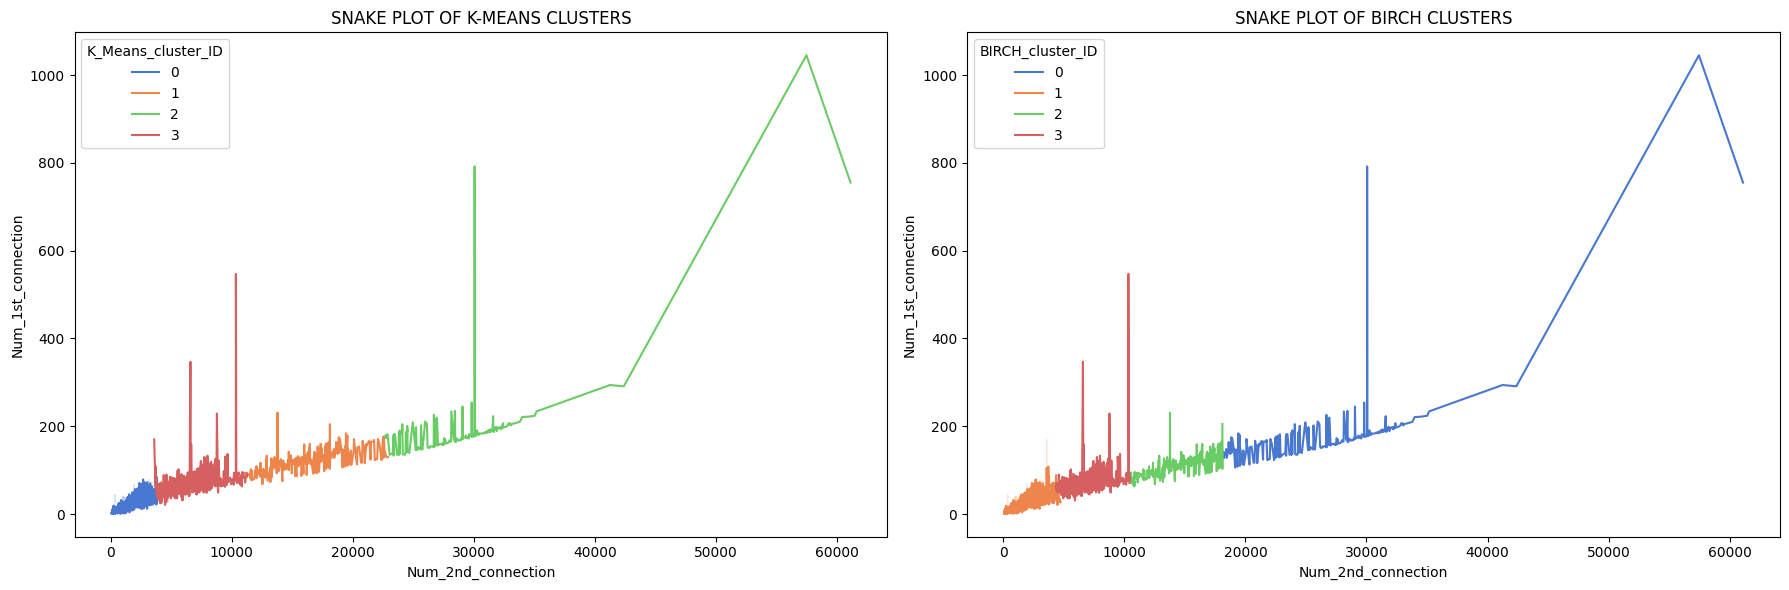

In [ ]:
# SIMILARITIES  BETWEEN K-MEANS AND BIRCH CLUSTERS
fig = plt.subplots(figsize=(18,6))
plt.subplot(1,2,1)
sns.lineplot(x='Num_2nd_connection',y='Num_1st_connection',data=X,hue='K_Means_cluster_ID',palette = sns.color_palette("muted"))
plt.title("SNAKE PLOT OF K-MEANS CLUSTERS")

plt.subplot(1,2,2)
sns.lineplot(x='Num_2nd_connection',y='Num_1st_connection',data=X,hue='BIRCH_cluster_ID',palette = sns.color_palette("muted"))
plt.title("SNAKE PLOT OF BIRCH CLUSTERS")

plt.tight_layout()
plt.show()